In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Bayesian Structural Causal Inference

When we ask "What is the effect of a medical treatment?" or "Does quitting smoking cause weight gain?" or "Do job training programs increase earnings?", we are not simply asking about the treatment itself. We are asking: What world are we operating in? This perspective is more easily seen if you imagine a causal analyst as a pet-shop owner introducing a new fish to one of their many acquariums. The new fish's survival and behavior depend less on its intrinsic properties than on how it fits within this complex, interconnected system. In which tank will the new fish thrive? 

There are a number of complementary paradigms in the causal inference literature, and in `CausalPy` we have not sought to be advocate for any one view over another. There are valuable lessons to be learned from econometrics, psychology and statistics whether they adopt a DAG or Potential outcomes framing for their causal work. Where the methods are statistically sound and practical we will seek to adopt and evangelise their usage. But in this article we want to focus on the idea of a causal model as a probabilistic program. An inferential routine designed to explicitly yield insights into the effect of some intervention or treatment on an outcome of interest. 

Some of the algorithms and routines available in `CausalPy` focus deriving insight from a known environment e.g. stationarity with interrupted time-series, parallel trends in difference-in-differences, positivity in propensity score weighting and strong instruments with instrumental variable designs. These methods rely on stated assumptions or facts about the environment in which the treatment takes place to justify their conclusions as causal claims. In Bayesian structural causal inference the focus is slightly different in that we wish to model both the treatment but also the environment i.e. the fish and the fishtank. In this article we'll outline a species of modelling that tries to infer structural attributes of the environment to underwrite causal claims. 

This is a two step move in the Bayesian paradigm. First we infer "backwards" what is the most plausible state of the world $w$ conditioned on the observable data. Then we assess the probabilistic predictive distribution of treatment and outcome at the plausible range of worlds. 

![](../_static/forwards_backwards.png)

The important point is that we characterise the plausible worlds by how much structure we learn about in the model specification. The more structure we seek to infer, the more we risk model misspecification, but simultaneously, the more structure we learn the more useful and transparent our conclusions. The "world" of the model is defined by the graph structure, latent confounders, link functions, measurement models and the implementation of selection mechanisms. Contrast this with the simpler case. When we regress an outcome $Y$ on a treatment $T$ and a set of covariates $X$,

$$Y = \alpha T + X \beta + \epsilon$$

the coefficient $\alpha$ captures the average change in Y associated with a one-unit change in $T$ — but only under strong assumptions can it be interpreted as a causal effect. In real-world settings, those assumptions (like exogeneity of $T$) are fragile:

- Confounding: Unobserved or omitted variables affect both 
$T$ and $Y$.

- Endogeneity: Treatment assignment mechanisms are correlated with the error term.

- Measurement uncertainty: Model parameters and predictions have uncertainty not captured by point estimates.

Bayesian probabilistic causal inference addresses these challenges by explicitly modelling the data-generating process and quantifying all sources of uncertainty.
Rather than point estimates, we infer full posterior distributions over causal parameters and even over counterfactual outcomes. Rather than isolating the outcome equation from the treatment equation, we model them together as parts of a single generative system. This approach mirrors how interventions occur in the real world: treatments have causes, and outcomes respond to both those treatments and shared confounders. When we fit such a model, we learn about every component simultaneously—the effect of the treatment, the influence of confounders, and the uncertainty that ties them together. Once fitted, Bayesian models can generate posterior predictive draws for “what if” scenarios. This capacity lets us compute causal estimands like the ATE or individual treatment effects directly from the posterior.

In this tutorial, we’ll move step by step from data simulation to Bayesian estimation:

:::{admonition} The Structure of the Document
:class: tip

- Simulate data with known causal structure (including confounding and exclusion restrictions).

- Fit and interpret Bayesian models for continuous treatments.

- Extend to binary treatments and potential outcomes.

- Use posterior predictive imputation to simulate counterfactuals.

- Demonstrate the relationship between the structural modelling perspective with the potential outcomes framework.

- Apply the model to an empircal example with parameter recovery checks and sensitivity analysis
:::


This approach will show how Bayesian methods provide a unified and transparent lens on causal inference. We will cover estimation, identification, and uncertainty in a single coherent framework.

### Simulating the Source of Truth

Before we fit any models, we need data whose causal structure is known. Simulation gives us a controlled environment where we can specify how treatments and outcomes are generated, introduce confounding deliberately, and then test whether our methods recover the truth. The function below constructs such a dataset.

In [29]:
np.random.seed(123)


def inv_logit(z):
    """Compute the inverse logit (sigmoid) of z."""
    return 1 / (1 + np.exp(-z))


def standardize_df(df, cols):
    means = df[cols].mean()
    sds = df[cols].std(ddof=1)
    df_s = (df[cols] - means) / sds
    return df_s, means, sds


def simulate_data(n=2500, alpha_true=3.0, rho=0.6, cate_estimation=False):
    # Exclusion restrictions:
    # X[0], X[1] affect both Y and D (confounders)
    # X[2], X[3] affect ONLY D (instruments for D)
    # X[4] affects ONLY Y (predictor of Y only)

    betaY = np.array([0.5, -0.3, 0.0, 0.0, 0.4, 0, 0, 0, 0])  # X[2], X[3] excluded
    betaD = np.array([0.7, 0.1, -0.4, 0.3, 0.0, 0, 0, 0, 0])  # X[4] excluded
    p = len(betaY)

    # noise variances and correlation
    sigma_U = 3.0
    sigma_V = 3.0

    # design matrix (n × p) with mean-zero columns
    X = np.random.normal(size=(n, p))
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    mean = [0, 0]
    cov = [[sigma_U**2, rho * sigma_U * sigma_V], [rho * sigma_U * sigma_V, sigma_V**2]]
    errors = np.random.multivariate_normal(mean, cov, size=n)
    U = errors[:, 0]  # error in outcome equation
    V = errors[:, 1]  #

    # continuous treatment
    T_cont = X @ betaD + V

    # latent variable for binary treatment
    T_latent = X @ betaD + V
    T_bin = np.random.binomial(n=1, p=inv_logit(T_latent), size=n)

    alpha_individual = 3.0 + 2.5 * X[:, 0]

    # outcomes
    Y_cont = alpha_true * T_cont + X @ betaY + U
    if cate_estimation:
        Y_bin = alpha_individual * T_bin + X @ betaY + U
    else:
        Y_bin = alpha_true * T_bin + X @ betaY + U

    # combine into DataFrame
    data = pd.DataFrame(
        {
            "Y_cont": Y_cont,
            "Y_bin": Y_bin,
            "T_cont": T_cont,
            "T_bin": T_bin,
        }
    )
    data["alpha"] = alpha_true + alpha_individual
    for j in range(p):
        data[f"feature_{j}"] = X[:, j]
    data["Y_cont_scaled"] = (data["Y_cont"] - data["Y_cont"].mean()) / data[
        "Y_cont"
    ].std(ddof=1)
    data["Y_bin_scaled"] = (data["Y_bin"] - data["Y_bin"].mean()) / data["Y_bin"].std(
        ddof=1
    )
    data["T_cont_scaled"] = (data["T_cont"] - data["T_cont"].mean()) / data[
        "T_cont"
    ].std(ddof=1)
    data["T_bin_scaled"] = (data["T_bin"] - data["T_bin"].mean()) / data["T_bin"].std(
        ddof=1
    )
    return data

Each simulated observation has a treatment $T$, an outcome $Y$, and a set of covariates $X$ with distinct causal roles. Two covariates influence both the treatment and the outcome—these are the confounders. Two others affect only the treatment and serve as valid instruments. A final covariate affects only the outcome. The treatment and outcome errors are drawn from a correlated bivariate normal distribution, introducing endogeneity through their correlation parameter $\rho$ . The treatment is exogenous and standard should regression recover the correct effect when $\rho$ is low; while naive estimates are biased when $\rho$ is high.

The function produces both continuous and binary versions of the treatment and the outcome. This dual design lets us explore two worlds side by side: one where the treatment is a continuous dosage, and another where it is a binary decision. In both cases, the true causal effect of the treatment on the outcome is set to three. Because we know the truth, we can evaluate how well our Bayesian models recover true parameters. Even here you can see that the "structure" we impose on the world is abstraction over the concrete mechanisms acting in the world. We bundle the idea of selecting into the treatment as potential for correlation between treatment and outcome. This is a convenient and tractable proxy of a range of concrete settings where there is a risk of selection effects in the real world. 

![](../_static/JOINT_DAG.png)

Additionally, we've allowed that the variables the treatment is not independent of the outcome due to shared predictors. Before introducing the Bayesian machinery, it’s worth revisiting what goes wrong with ordinary least squares when the treatment and outcome share unobserved causes. The following code performs a simple sensitivity experiment: we vary the correlation $\rho$ between the unobserved treatment and outcome errors and examine how the estimated treatment effect changes.

In [32]:
data = simulate_data(n=2500, alpha_true=3, rho=0.6)
features = [col for col in data.columns if "feature" in col]

treatment_effects_binary = []
treatment_effects_continuous = []
df_params = {
    "treatment_effects_binary": [],
    "treatment_effects_continuous": [],
    "rho": [],
}
formula_cont = "Y_cont ~ T_cont + " + " + ".join(features)
formula_bin = "Y_bin ~ T_bin + " + " + ".join(features)
for rho in np.linspace(-1, 1, 10):
    data = simulate_data(n=2500, alpha_true=3, rho=rho)
    model_cont = smf.ols(formula_cont, data=data).fit()
    model_bin = smf.ols(formula_bin, data=data).fit()
    df_params["treatment_effects_continuous"].append(model_cont.params["T_cont"])
    df_params["treatment_effects_binary"].append(model_bin.params["T_bin"])
    df_params["rho"].append(rho)

df_params = pd.DataFrame(df_params)
df_params

,treatment_effects_binary,treatment_effects_continuous,rho
0,-0.967809,2.000000,-1.000000
1,-0.396761,2.203657,-0.777778
2,0.730987,2.430423,-0.555556
3,1.749709,2.662076,-0.333333
4,2.241520,2.856044,-0.111111
5,3.419014,3.110280,0.111111
6,4.480844,3.342901,0.333333
7,5.318152,3.530133,0.555556
8,6.226356,3.786272,0.777778
9,7.154482,4.000000,1.000000


This loop re-simulates the dataset ten times, each with a different value of $\rho$, ranging from –1 to 1. For each dataset, it fits two OLS regressions: one for the continuous treatment, and another for the binary treatment, both controlling for all observed covariates. The estimated coefficient on the treatment variable `T_cont` or `T_bin`—represents what OLS believes to be the causal effect. By collecting these estimates in df_params, we can plot them against the true correlation to see how endogeneity distorts inference.

When $\rho = 0$ the treatment and outcome errors are independent, and OLS recovers the true causal effect of 3. But as $\rho$ grows, the estimates drift away from the truth, sometimes dramatically. The direction of bias depends on the sign of if unobserved factors push both treatment and outcome in the same direction, OLS overstates the effect; if they push in opposite directions, it understates it. Even though we’ve controlled for all observed features, the unobserved correlation sneaks bias into our estimates.

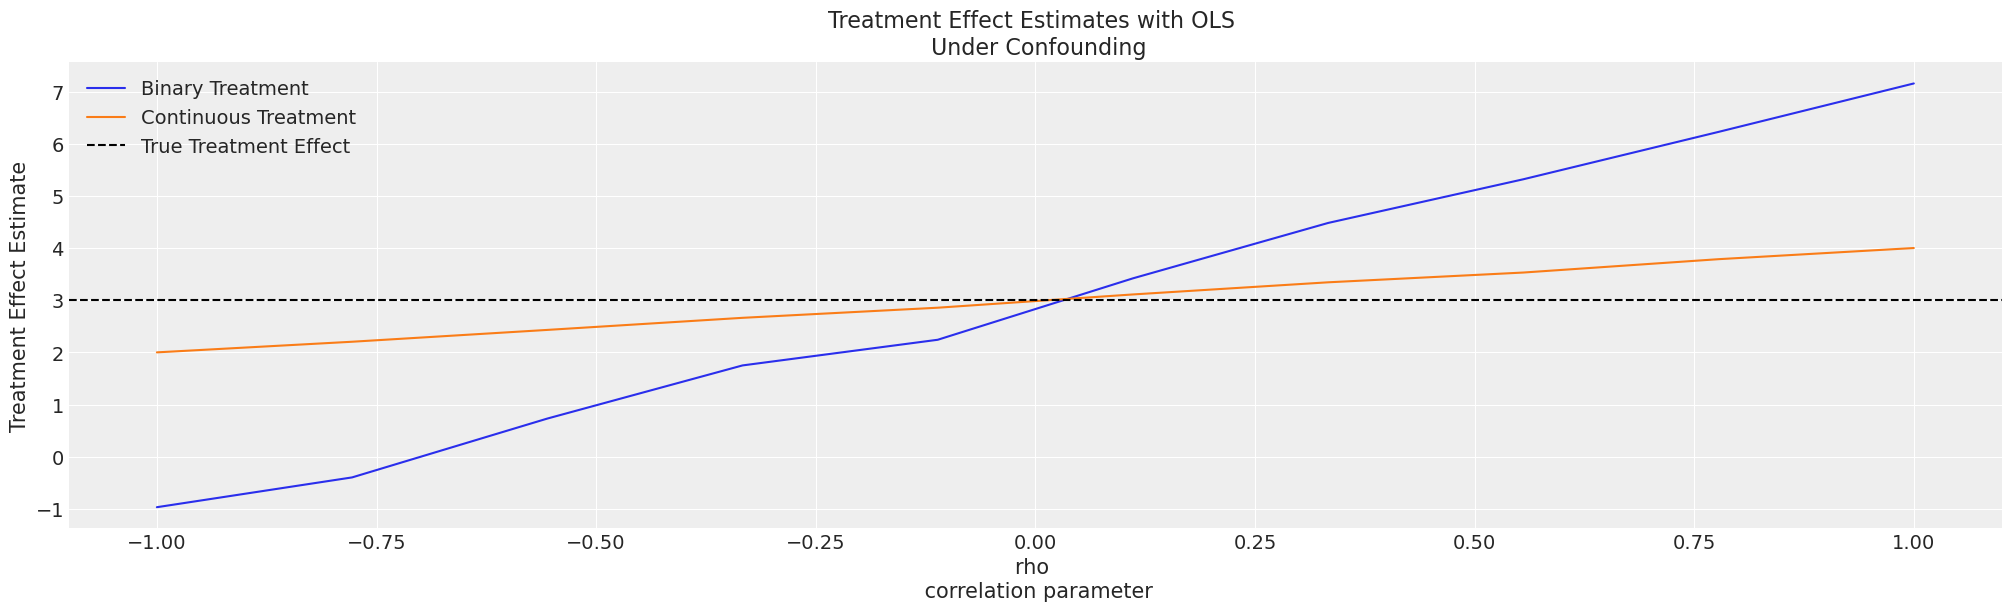

In [33]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(
    df_params["rho"], df_params["treatment_effects_binary"], label="Binary Treatment"
)
ax.plot(
    df_params["rho"],
    df_params["treatment_effects_continuous"],
    label="Continuous Treatment",
)
ax.axhline(3, linestyle="--", color="k", label="True Treatment Effect")
ax.set_xlabel("rho \n correlation parameter")
ax.set_ylabel("Treatment Effect Estimate")
ax.set_title("Treatment Effect Estimates with OLS \n Under Confounding")
ax.legend();

We now move from diagnosing bias to building a model that can recover causal effects under controlled conditions. To keep things interpretable, we begin with the unconfounded case, where the treatment and outcome share no latent correlation ($\rho=0$). This setting lets us isolate what a Bayesian structural model actually does before we expose it to the challenges of endogeneity.

At the heart of our approach is joint modelling: instead of fitting separate regressions for treatment and outcome, we model them together as draws from a joint multivariate distribution. The treatment equation captures how covariates predict exposure, while the outcome equation captures how both treatment and covariates predict the response. By expressing them jointly, we retain the covariance structure between their errors—an essential ingredient for causal inference once we later introduce confounding.

The model is built using PyMC and organized through the function `make_joint_model()`. Each version shares the same generative logic but differs in how the priors handle variable selection and identification. We can think of these as different “dial settings” for how strongly the model shrinks irrelevant coefficients or searches for valid instruments. Four prior configurations are explored:

- A normal prior, serving as a baseline regularized regression with weakly informative priors on all coefficients.

- A spike-and-slab prior, which aggressively prunes away variables unlikely to matter, allowing the model to discover which features are true confounders or instruments.

- A horseshoe prior, offering continuous shrinkage that downweights noise while preserving large signals.

- An exclusion-restriction prior, explicitly encoding which variables are allowed to influence the treatment but not the outcome, mimicking an instrumental-variable design.

In the unconfounded case, the treatment and outcome errors are independent, so the joint model effectively decomposes into two connected regressions. The treatment effect $\alpha$ then captures the causal impact of the treatment on the outcome, and under this setting, its posterior should center around the true value of 3. The goal is not to solve confounding yet but to show that when the world is simple and well-behaved, the Bayesian model recovers the truth just as OLS does—but with richer uncertainty quantification and a coherent probabilistic structure.

The following code defines the model and instantiates it under several prior choices. The model’s graphical representation, produced by `pm.model_to_graphviz()`, visualizes its structure: covariates feed into both the treatment and the outcome equations, the treatment coefficient $\alpha$ links them, and the two residuals 
$U$ and $V$ are connected through a correlation parameter $\rho$, which we can freely set to zero or more substantive values. These parameterisations offer us a way to derive insight into the structure of the causal system under study. 

### Fitting the Continuous Treatment Model

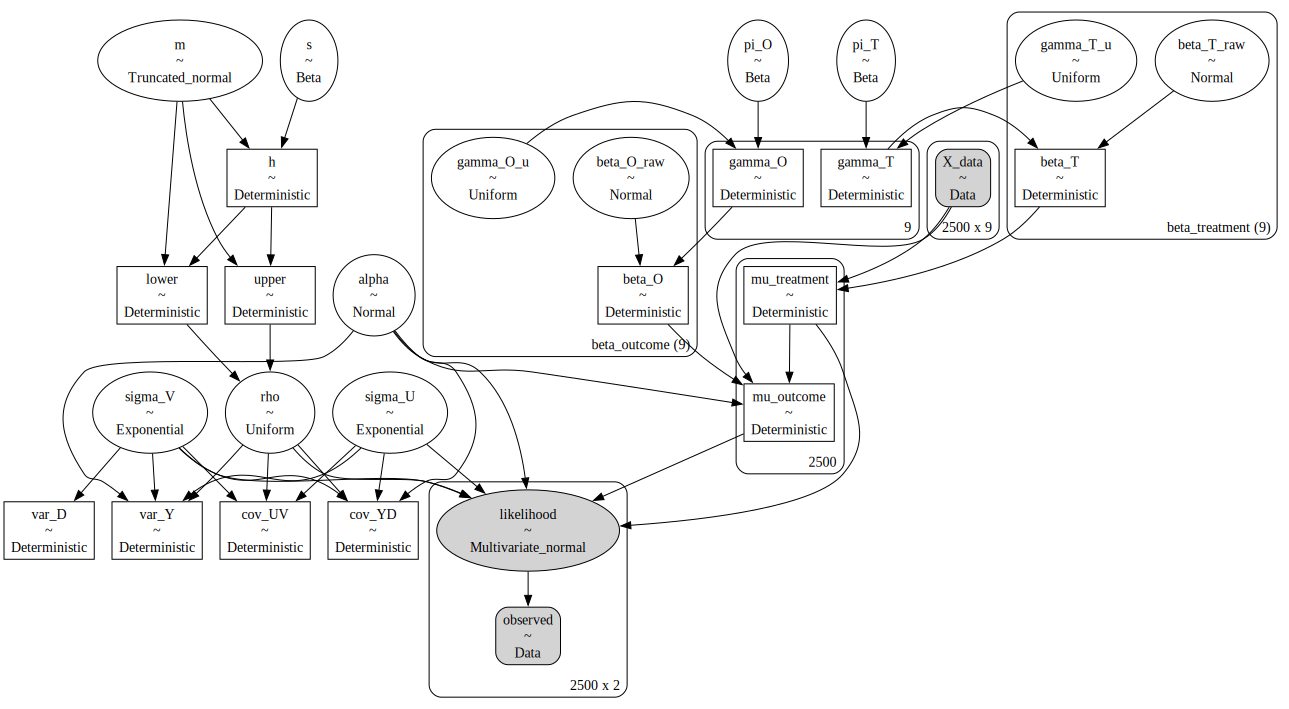

In [34]:
coords = {
    "beta_outcome": [col for col in data.columns if "feature" in col],
    "beta_treatment": [col for col in data.columns if "feature" in col],
    "obs": range(data.shape[0]),
    "latent": ["U", "V"],
    "sigmas_1": ["var_U", "cov_UV"],
    "sigmas_2": ["cov_VU", "var_V"],
}


def relaxed_bernoulli(name, p, temperature=0.1, dims=None):
    u = pm.Uniform(name + "_u", 0, 1, dims=dims)
    logit_p = pt.log(p) - pt.log(1 - p)
    return pm.Deterministic(
        name, pm.math.sigmoid((logit_p + pt.log(u) - pt.log(1 - u)) / temperature)
    )


def make_joint_model(X, Y, T, coords, priors_type="normal", priors={}):
    p = X.shape[1]
    p0 = 5.0  # pick an expected number of nonzero coeffs
    sigma_est = 1.0

    tau0 = (p0 / (p - p0)) * (sigma_est / np.sqrt(X.shape[0]))

    with pm.Model(coords=coords) as dml_model:
        spike_and_slab = priors_type == "spike_and_slab"
        horseshoe = priors_type == "horseshoe"
        exclusion_restriction = priors_type == "exclusion_restriction"
        p = X.shape[1]

        if not priors:
            priors = {
                "rho": [-0.99, 0.99],
            }

        if spike_and_slab:
            # RELAXED SPIKE-AND-SLAB PRIORS for aggressive variable selection

            pi_O = pm.Beta("pi_O", alpha=2, beta=2)
            beta_O_raw = pm.Normal("beta_O_raw", mu=0, sigma=2, dims="beta_outcome")
            gamma_O = relaxed_bernoulli(
                "gamma_O", pi_O, temperature=0.1, dims="beta_outcome"
            )
            beta_outcome = pm.Deterministic(
                "beta_O", gamma_O * beta_O_raw, dims="beta_outcome"
            )

            pi_T = pm.Beta("pi_T", alpha=2, beta=2)
            beta_T_raw = pm.Normal("beta_T_raw", mu=0, sigma=2, dims="beta_treatment")
            gamma_T = relaxed_bernoulli(
                "gamma_T", pi_T, temperature=0.1, dims="beta_treatment"
            )
            beta_treatment = pm.Deterministic(
                "beta_T", gamma_T * beta_T_raw, dims="beta_treatment"
            )

        elif horseshoe:
            tau_O = pm.HalfStudentT("tau_O", nu=3, sigma=tau0)
            # Local shrinkage parameters (one per coefficient)
            lambda_O = pm.HalfCauchy("lambda_O", beta=1.0, dims="beta_outcome")
            # Regularized horseshoe: c² controls tail behavior
            c2_O = pm.InverseGamma("c2_O", alpha=2, beta=2)
            lambda_tilde_O = pm.Deterministic(
                "lambda_tilde_O",
                pm.math.sqrt(c2_O * lambda_O**2 / (c2_O + tau_O**2 * lambda_O**2)),
                dims="beta_outcome",
            )

            # Outcome coefficients with horseshoe prior
            beta_O_raw = pm.Normal("beta_O_raw", mu=0, sigma=1, dims="beta_outcome")
            beta_outcome = pm.Deterministic(
                "beta_O", beta_O_raw * lambda_tilde_O * tau_O, dims="beta_outcome"
            )

            # Same for treatment equation
            tau_T = pm.HalfStudentT("tau_T", nu=3, sigma=tau0)
            lambda_T = pm.HalfCauchy("lambda_T", beta=1.0, dims="beta_treatment")
            c2_T = pm.InverseGamma("c2_T", alpha=2, beta=2)
            lambda_tilde_T = pm.Deterministic(
                "lambda_tilde_T",
                pm.math.sqrt(c2_T * lambda_T**2 / (c2_T + tau_T**2 * lambda_T**2)),
                dims="beta_treatment",
            )

            beta_T_raw = pm.Normal("beta_T_raw", mu=0, sigma=1, dims="beta_treatment")
            beta_treatment = pm.Deterministic(
                "beta_T", beta_T_raw * lambda_tilde_T * tau_T, dims="beta_treatment"
            )
        elif exclusion_restriction:
            ### Ensuring that there is an instruments i.e. predictors of the treatment that
            ### impact the outcome only through the treatment
            beta_outcome = pm.Normal(
                "beta_O",
                0,
                [2.0, 2.0, 0.001, 0.001, 2.0, 2, 2, 2, 2],
                dims="beta_outcome",
            )
            beta_treatment = pm.Normal(
                "beta_T",
                0,
                [2.0, 2.0, 2.0, 2.0, 0.001, 2, 2, 2, 2],
                dims="beta_treatment",
            )
        else:
            beta_outcome = pm.Normal("beta_O", 0, 1, dims="beta_outcome")
            beta_treatment = pm.Normal("beta_T", 0, 1, dims="beta_treatment")

        X_data = pm.Data("X_data", X.values)
        observed_data = pm.Data("observed", np.column_stack([Y.values, T.values]))

        alpha = pm.Normal("alpha", mu=0, sigma=5)

        # Error standard deviations
        sigma_U = pm.Exponential("sigma_U", 1.0)
        sigma_V = pm.Exponential("sigma_V", 1.0)

        # Correlation between errors (confounding parameter)
        m = pm.TruncatedNormal(
            "m", mu=0, sigma=0.5, lower=priors["rho"][0], upper=priors["rho"][1]
        )
        s = pm.Beta("s", 2, 2)  # scaled half-width
        h = pm.Deterministic("h", s * (priors["rho"][1] - pm.math.abs(m)))
        lower = pm.Deterministic("lower", m - h)
        upper = pm.Deterministic("upper", m + h)
        rho = pm.Uniform("rho", lower, upper)

        mu_treatment = pm.Deterministic("mu_treatment", X_data @ beta_treatment)
        mu_outcome = pm.Deterministic(
            "mu_outcome", X_data @ beta_outcome + alpha * mu_treatment
        )

        var_D = sigma_V**2
        var_Y = alpha**2 * sigma_V**2 + sigma_U**2 + 2 * alpha * rho * sigma_U * sigma_V
        cov_YD = alpha * sigma_V**2 + rho * sigma_U * sigma_V

        # Build 2x2 covariance matrix
        cov = pm.math.stack([[var_Y, cov_YD], [cov_YD, var_D]])

        # Store as deterministic for inspection
        _ = pm.Deterministic("var_Y", var_Y)
        _ = pm.Deterministic("var_D", var_D)
        _ = pm.Deterministic("cov_YD", cov_YD)
        _ = pm.Deterministic("cov_UV", rho * sigma_U * sigma_V)

        mu = pm.math.stack([mu_outcome, mu_treatment], axis=1)  # shape (n,2)
        _ = pm.MvNormal("likelihood", mu=mu, cov=cov, observed=observed_data)

    return dml_model


def make_continuous_models(data):
    X = data[[col for col in data.columns if "feature" in col]]
    Y = data["Y_cont"]
    T = data["T_cont"]

    coords = {
        "beta_outcome": [col for col in data.columns if "feature" in col],
        "beta_treatment": [col for col in data.columns if "feature" in col],
        "obs": range(data.shape[0]),
    }

    spike_and_slab = make_joint_model(X, Y, T, coords, priors_type="spike_and_slab")
    horseshoe = make_joint_model(X, Y, T, coords, priors_type="horseshoe")
    excl = make_joint_model(X, Y, T, coords, priors_type="exclusion_restriction")
    normal = make_joint_model(X, Y, T, coords, priors_type="normal")
    tight_rho = make_joint_model(
        X, Y, T, coords, priors_type="normal", priors={"rho": [0.4, 0.99]}
    )
    tight_rho_s_s = make_joint_model(
        X, Y, T, coords, priors_type="spike_and_slab", priors={"rho": [0.4, 0.99]}
    )

    models = {
        "spike_and_slab": spike_and_slab,
        "horseshoe": horseshoe,
        "exclusion": excl,
        "normal": normal,
        "tight_rho": tight_rho,
        "tight_rho_s_s": tight_rho_s_s,
    }
    return models


data_confounded = simulate_data(n=2500, alpha_true=3, rho=0.6)
data_unconfounded = simulate_data(n=2500, alpha_true=3, rho=0)

models_confounded = make_continuous_models(data_confounded)
models_unconfounded = make_continuous_models(data_unconfounded)

pm.model_to_graphviz(models_confounded["spike_and_slab"])

This section orchestrates the fitting and sampling workflow for the suite of Bayesian models defined earlier. Having specified several variants of the joint outcome–treatment model—each differing only in its prior structure or treatment of the correlation parameter $\rho$—we now turn to posterior inference.

The functions `sample_model()`, and `fit_models()` provide a compact, repeatable sampling pipeline. Within the model context, it first draws from the prior predictive distribution, capturing what the model believes about the data before seeing any observations. These are comparable across each of models specified.
We're moving from describing how the data are assumed to arise, to actually learning from the simulated observations. This is the backwards inference step. The output `idata_unconfounded` contains all posterior draws, prior predictive samples, and posterior predictive simulations for every model variant under the assumption of no confounding. This will allow us to compare the inferences achieved under each setting. To gauge which are the most plausible parameterisations of the world-state conditioned on the data and our model-specification.

In [6]:
def sample_model(model, fit_kwargs):
    with model:
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(draws=1000, tune=2000, target_accept=0.95, **fit_kwargs))
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata


fit_kwargs = {}


def fit_models(fit_kwargs, models):
    idata_spike_and_slab = sample_model(models["spike_and_slab"], fit_kwargs=fit_kwargs)
    idata_horseshoe = sample_model(models["horseshoe"], fit_kwargs=fit_kwargs)
    idata_excl = sample_model(models["exclusion"], fit_kwargs=fit_kwargs)
    idata_normal = sample_model(models["normal"], fit_kwargs=fit_kwargs)
    idata_normal_rho_tight = sample_model(models["tight_rho"], fit_kwargs=fit_kwargs)
    idata_rho_tight_s_s = sample_model(models["tight_rho_s_s"], fit_kwargs=fit_kwargs)

    idatas = {
        "spike_and_slab": idata_spike_and_slab,
        "horseshoe": idata_horseshoe,
        "exclusion": idata_excl,
        "normal": idata_normal,
        "rho_tight": idata_normal_rho_tight,
        "rho_tight_spike_slab": idata_rho_tight_s_s,
    }

    return idatas


idata_unconfounded = fit_models(fit_kwargs, models_unconfounded)

Sampling: [alpha, beta_O_raw, beta_T_raw, gamma_O_u, gamma_T_u, likelihood, m, pi_O, pi_T, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi_O, beta_O_raw, gamma_O_u, pi_T, beta_T_raw, gamma_T_u, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 394 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O_raw, beta_T_raw, c2_O, c2_T, lambda_O, lambda_T, likelihood, m, rho, s, sigma_U, sigma_V, tau_O, tau_T]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_O, lambda_O, c2_O, beta_O_raw, tau_T, lambda_T, c2_T, beta_T_raw, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 149 seconds.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O, beta_T, likelihood, m, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O, beta_T, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 91 seconds.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O, beta_T, likelihood, m, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O, beta_T, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 120 seconds.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O, beta_T, likelihood, m, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O, beta_T, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 86 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O_raw, beta_T_raw, gamma_O_u, gamma_T_u, likelihood, m, pi_O, pi_T, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi_O, beta_O_raw, gamma_O_u, pi_T, beta_T_raw, gamma_T_u, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 371 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Before examining how different priors shape inference, it’s useful to clarify what our models are actually estimating. Each specification—spike-and-slab, horseshoe, exclusion restriction, and the others—ultimately targets the same estimand: the slope $\alpha$ that captures how changes in the continuous treatment $T$ shift the expected outcome $Y$. In this setup, $\alpha$ functions as a regression coefficient within the structural equation of our joint model. 

In econometric terms, what we’ve done so far sits squarely within the structural modelling tradition. We’ve written down a joint model for both the treatment and the outcome, specified their stochastic dependencies explicitly, and interpreted the slope $\alpha$ as a structural parameter — a feature of the data-generating process itself. This parameter has a causal meaning only insofar as the model is correctly specified: if the structural form reflects how the world actually works, 
$\alpha$ recovers the true causal effect. By contrast, reduced-form econometrics focuses less on modelling the underlying mechanisms and more on identifying causal effects through research design — instrumental variables, difference-in-differences, or randomization. Reduced-form approaches avoid the need to specify the joint distribution of unobservables but often sacrifice interpretability: they estimate relationships that are valid for specific interventions or designs, not necessarily structural primitives.

### Plotting Treatment Estimates

The comparison of models is a form of robustness checks. We want to inspect how consistent our parameter estimates are across different model specifications. 

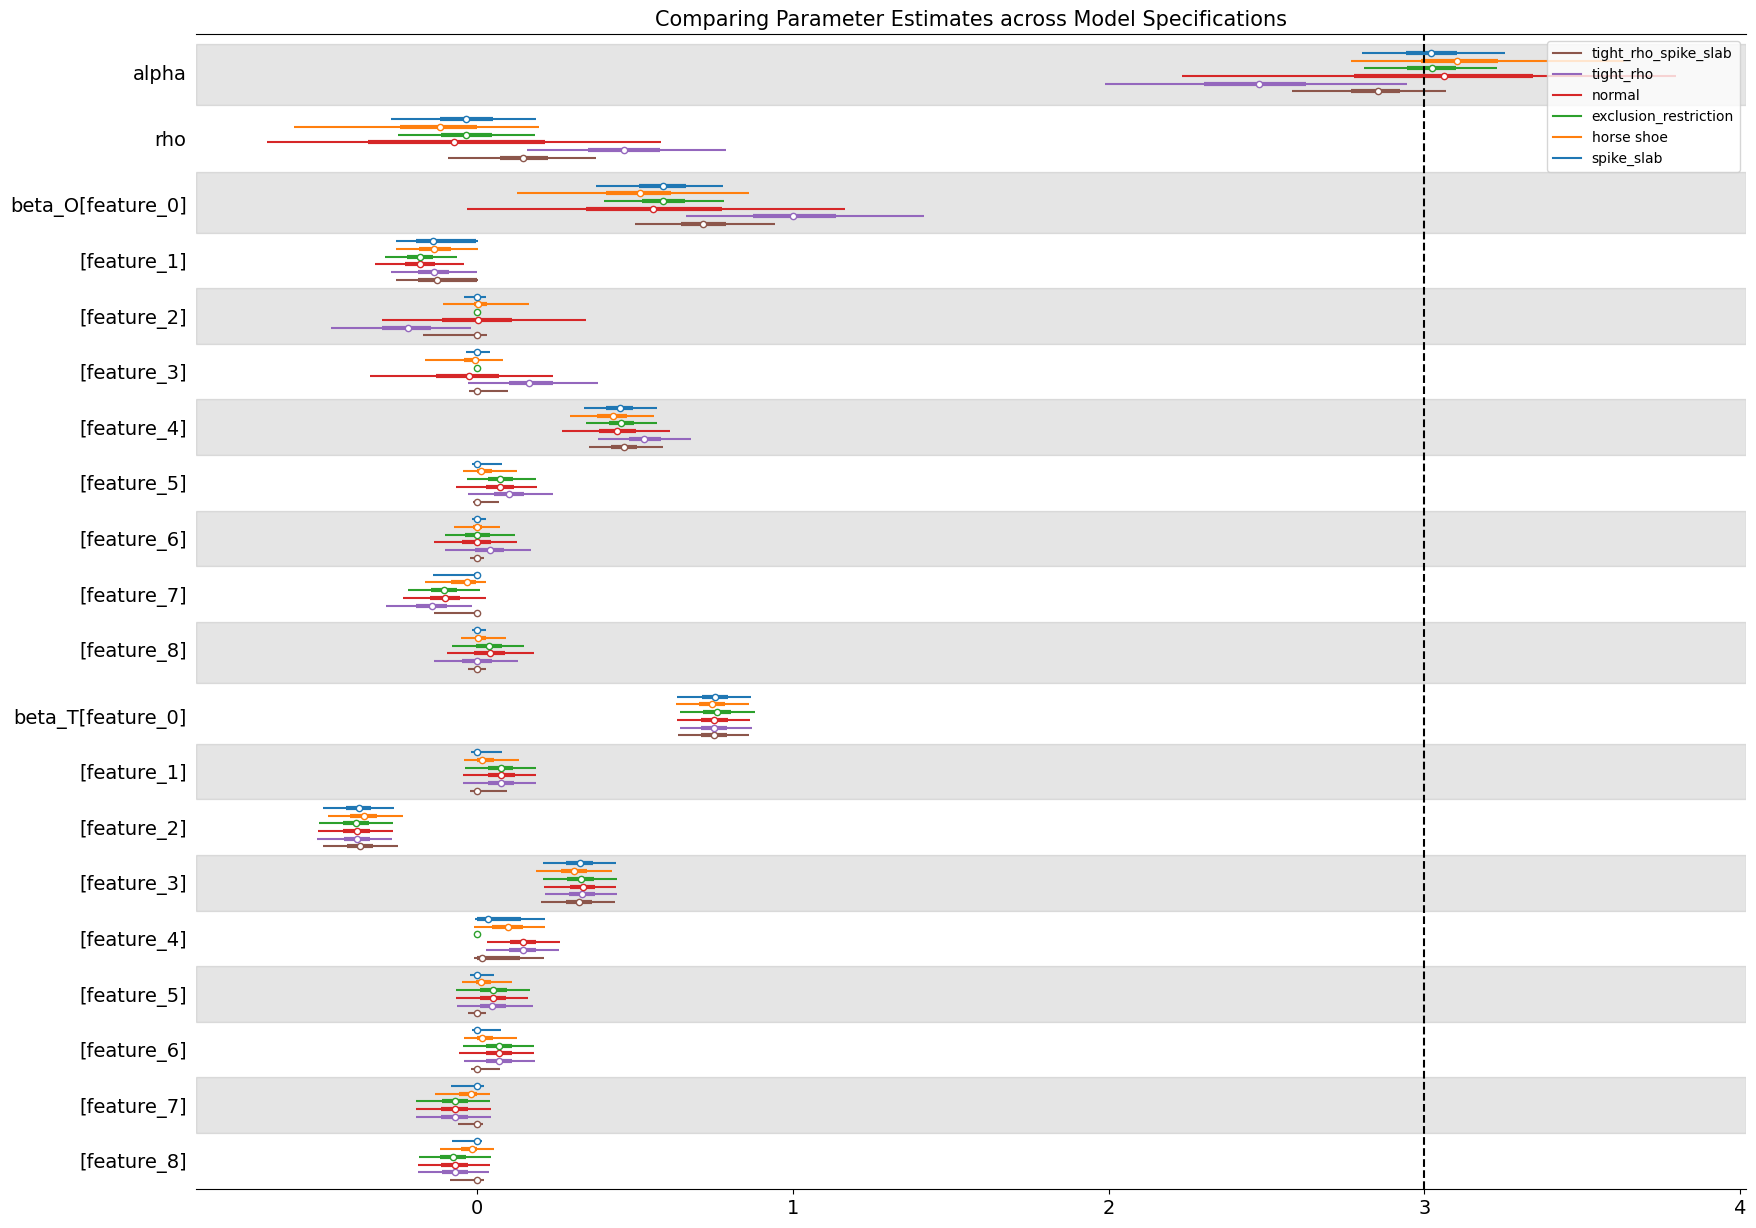

In [7]:
ax = az.plot_forest(
    [
        idata_unconfounded["spike_and_slab"],
        idata_unconfounded["horseshoe"],
        idata_unconfounded["exclusion"],
        idata_unconfounded["normal"],
        idata_unconfounded["rho_tight"],
        idata_unconfounded["rho_tight_spike_slab"],
    ],
    var_names=["alpha", "rho", "beta_O", "beta_T"],
    combined=True,
    model_names=[
        "spike_slab",
        "horse shoe",
        "exclusion_restriction",
        "normal",
        "tight_rho",
        "tight_rho_spike_slab",
    ],
    figsize=(20, 15),
)

ax[0].axvline(3, linestyle="--", color="k")
ax[0].set_title(
    "Comparing Parameter Estimates across Model Specifications", fontsize=15
);

In the plot we can see that the majority of models accurately estimate the true treatment effect $\alpha$ except in the cases where we have explicitly placed an opinionated prior on the $\rho$ parameter in the model. These priors pull the $\alpha$ estimate away from the true data generating process. 

Our Bayesian setup here is intentionally structural. We specify how both treatment and outcome arise from common covariates and latent confounding structures. However, the boundary between structural and reduced-form reasoning becomes fluid when we begin to treat latent variables or exclusion restrictions as data-driven “instruments.” In that sense, the structural Bayesian approach can emulate reduced-form logic within a generative model — an idea we’ll develop when we move from unconfounded to confounded data and later when we impute potential outcomes directly. But for now let's continue to examine the relationships between these structural parameters. 

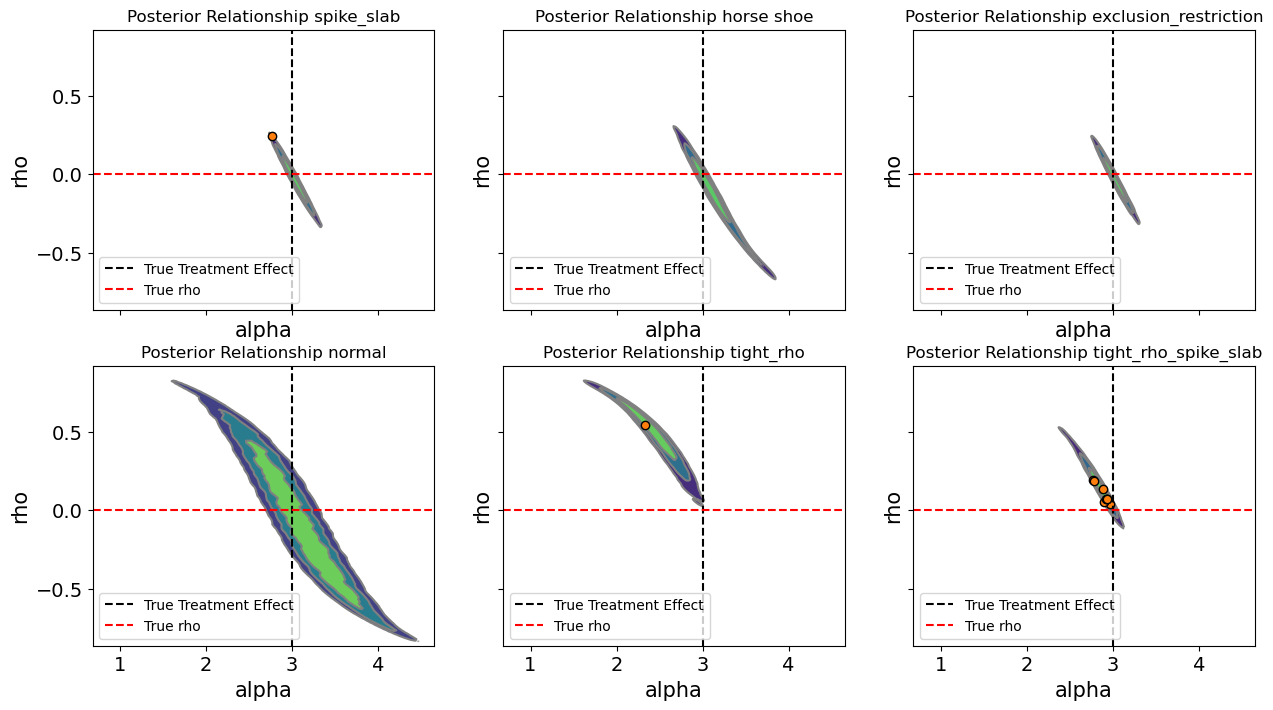

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axs = axs.flatten()
az.plot_pair(
    idata_unconfounded["spike_and_slab"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[0],
)
az.plot_pair(
    idata_unconfounded["horseshoe"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[1],
)
az.plot_pair(
    idata_unconfounded["exclusion"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[2],
)
az.plot_pair(
    idata_unconfounded["normal"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[3],
)
az.plot_pair(
    idata_unconfounded["rho_tight"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[4],
)
az.plot_pair(
    idata_unconfounded["rho_tight_spike_slab"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[5],
)
for ax, m in zip(
    axs,
    [
        "spike_slab",
        "horse shoe",
        "exclusion_restriction",
        "normal",
        "tight_rho",
        "tight_rho_spike_slab",
    ],
):
    ax.axvline(3, linestyle="--", color="k", label="True Treatment Effect")
    ax.axhline(0, linestyle="--", color="red", label="True rho")
    ax.set_title(f"Posterior Relationship {m}")
    ax.legend(loc="lower left")

Up to this point, we have looked at posterior summaries of individual parameters, such as the treatment effect $\alpha$ or the correlation $\rho$. While these marginal summaries are useful, they can obscure important interactions between parameters. In a structural model, the slope $\alpha$ does not exist in isolation. Its interpretation depends on the joint distribution of the latent errors and the covariates that generate the treatment and outcome.

The pairwise posterior plots below examine the joint distributions of $\alpha$ and $\rho$ and across different prior specifications. Each subplot shows the density of the posterior draws, highlighting how the inferred treatment effect co-varies with the estimated correlation between latent errors. The dashed vertical line marks the true causal effect, and the horizontal line shows the true values. 

By inspecting these joint distributions, we gain several insights: aggressive priors on $\rho$ can pull the posterior of away from zero, which in turn shifts the distribution of the treatment effect estimate. But additionlly variable selection schemes like the spike-and-slab or horseshoe can significantly reduce uncertainty in the estimation of both $\rho$ and $\alpha$. This illustrates the trade-off between automated variable selection, prior specification. 

In [9]:
df_params = pd.concat(
    {
        "rho_tight": az.summary(
            idata_unconfounded["rho_tight"], var_names=["alpha", "rho"]
        ),
        "normal": az.summary(idata_unconfounded["normal"], var_names=["alpha", "rho"]),
        "spike_slab": az.summary(
            idata_unconfounded["spike_and_slab"], var_names=["alpha", "rho"]
        ),
        "horseshoe": az.summary(
            idata_unconfounded["horseshoe"], var_names=["alpha", "rho"]
        ),
        "exclusion_restriction": az.summary(
            idata_unconfounded["exclusion"], var_names=["alpha", "rho"]
        ),
        "tight_rho_spike_slab": az.summary(
            idata_unconfounded["rho_tight_spike_slab"], var_names=["alpha", "rho"]
        ),
    }
)

df_params

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
rho_tight             alpha  2.449  0.258   1.989    2.945      0.008   
                      rho    0.459  0.167   0.159    0.788      0.005   
normal                alpha  3.059  0.426   2.232    3.797      0.021   
                      rho   -0.061  0.356  -0.665    0.583      0.017   
spike_slab            alpha  3.023  0.124   2.801    3.254      0.003   
                      rho   -0.033  0.125  -0.273    0.189      0.003   
horseshoe             alpha  3.133  0.220   2.767    3.633      0.012   
                      rho   -0.135  0.197  -0.578    0.197      0.010   
exclusion_restriction alpha  3.024  0.115   2.808    3.231      0.003   
                      rho   -0.035  0.118  -0.249    0.185      0.003   
tight_rho_spike_slab  alpha  2.829  0.147   2.579    3.068      0.008   
                      rho    0.160  0.129  -0.091    0.378      0.006   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
rho_tight             alpha    0.006    1059.0    1340.0   1.01  
                      rho      0.003    1055.0    1354.0   1.01  
normal                alpha    0.015     405.0     643.0   1.01  
                      rho      0.008     405.0     652.0   1.01  
spike_slab            alpha    0.003    1669.0    1622.0   1.00  
                      rho      0.003    1668.0    1512.0   1.00  
horseshoe             alpha    0.013     478.0     225.0   1.01  
                      rho      0.008     477.0     225.0   1.01  
exclusion_restriction alpha    0.002    1787.0    1680.0   1.00  
                      rho      0.002    1798.0    1645.0   1.00  
tight_rho_spike_slab  alpha    0.013     662.0     286.0   1.00  
                      rho      0.008     667.0     288.0   1.00

The table highlights the model's sensitivity to priors. Sparse priors, like spike-and-slab and horseshoe, can slightly shrink coefficients and influence the posterior spread, particularly for $\rho$, but strong priors directly on $\rho$ can negatively impact the estimation routine. especially when there is no true correlation. This is not a flaw. It is a feature. In practical settings, treatments and outcomes are often correlated due to unobserved confounding, measurement error, or endogenous selection. For example, in a health economics study, patients who choose a particular therapy may do so because of unobserved health determinents that also influence recovery—such as risk tolerance, underlying severity, or access to informal support. In labor economics, higher wages may appear to cause greater job satisfaction, but workers who are more motivated or more socially connected might self-select into higher-paying jobs, creating correlation between the unobserved determinants of treatment and outcome By exposing the model to different prior assumptions, we can probe how strong beliefs about sparsity or instrument validity propagate into causal estimates.

In other words, prior sensitivity is a diagnostic tool as much as a regularization mechanism. When $\rho$ is expected to be nonzero i.e. in observational studies with likely latent confounding, then explicitly modelling its distribution becomes crucial. The unconfounded case, therefore, serves as a baseline: it confirms that our joint Bayesian model can recover true parameters when the world is simple, while setting the stage for exploring more realistic, confounded scenarios where these structural dependencies must be handled carefully.

### The Confounded Case

While the unconfounded case provides a useful benchmark, most real-world observational studies involve some degree of endogenous treatment assignment. In our simulations, this occurs when the residuals of the treatment and outcome equations are correlated. This demonstrates that controlling only for measured variables is insufficient when unobserved confounders influence both treatment and outcome.

The Bayesian joint model provides a principled solution. By explicitly modelling the correlation between treatment and outcome residuals, the framework can adjust for latent confounding while still estimating the causal slope $\alpha$. Moreover, flexible priors such as spike-and-slab and horseshoe allow the model to automatically discover potential instruments i.e. covariates that predict the treatment but not the outcome. The theory is that the instrument structure if it holds in the world is also the one which best calibrates our parameters. These instruments help disentangle the structural effect of the treatment from latent correlations, improving identification.

By setting $\rho$ = 0.6 we simulate a moderate level of confounding—similar in spirit to cases where unmeasured preferences, abilities, or environmental factors drive both exposure and response. Conceptually, this setup mimics situations such as:

-  More health-conscious individuals being both more likely to adopt a preventive therapy and more likely to recover quickly.

- High-income households being more likely to invest in cleaner technologies and experience better environmental outcomes.

- Firms with stronger internal capabilities both adopting new management practices and achieving higher productivity.

Under such conditions, simple regression cannot disentangle correlation from causation, as the treatment is no longer independent of the unobserved outcome drivers.


In [10]:
idata_confounded = fit_models(fit_kwargs, models_confounded)

Sampling: [alpha, beta_O_raw, beta_T_raw, gamma_O_u, gamma_T_u, likelihood, m, pi_O, pi_T, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi_O, beta_O_raw, gamma_O_u, pi_T, beta_T_raw, gamma_T_u, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 471 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O_raw, beta_T_raw, c2_O, c2_T, lambda_O, lambda_T, likelihood, m, rho, s, sigma_U, sigma_V, tau_O, tau_T]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_O, lambda_O, c2_O, beta_O_raw, tau_T, lambda_T, c2_T, beta_T_raw, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 258 seconds.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O, beta_T, likelihood, m, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O, beta_T, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 144 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O, beta_T, likelihood, m, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O, beta_T, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 131 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O, beta_T, likelihood, m, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O, beta_T, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 98 seconds.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O_raw, beta_T_raw, gamma_O_u, gamma_T_u, likelihood, m, pi_O, pi_T, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi_O, beta_O_raw, gamma_O_u, pi_T, beta_T_raw, gamma_T_u, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 453 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

The forest plot below compares posterior estimates of the treatment effect ($\alpha$) and the confounding correlation ($\rho$) across model specifications when 
$\rho = .6$ in the data-generating process. The baseline normal model (which places diffuse priors on all parameters) clearly reflects the presence of endogeneity. Its posterior mean for $\alpha$ is biased upward relative to the true value of 3, and the estimated $\rho$ is positive, confirming that the model detects correlation between treatment and outcome disturbances. This behaviour mirrors the familiar bias of OLS under confounding: without structural constraints or informative priors, the model attributes part of the outcome variation caused by unobserved factors to the treatment itself. This inflates and corrupts our treatment effect estimate. 

By contrast, models that introduce structure through priors—either by tightening the prior range on $\rho$ or imposing shrinkage on the regression coefficients—perform noticeably better. The tight-$\rho$ models regularize the latent correlation, effectively limiting the extent to which endogeneity can distort inference, while spike-and-slab and horseshoe priors perform selective shrinkage on the covariates, allowing the model to emphasize variables that genuinely predict the treatment. This helps isolate more valid “instrument-like” components of variation, pulling the posterior of $\alpha$ closer to the true causal effect. 

The exclusion-restriction specification, which enforces prior beliefs about which covariates affect only the treatment or only the outcome, performs well too. The imposed restrictions recover both the correct treatment effect and a tight estimate of residual correlation. It may be wishful thinking that this precise instrument structure is available to an analyst in the applied setting, but instrument variable designs and their imposed exclusion restrictions should be motivated by theory. Where that theory is plausible we can hope for such precise estimates.

Together, these results illustrate the power of Bayesian joint modelling: even in the presence of confounding, appropriate prior structure enables partial recovery of causal effects. Importantly, the priors do not simply “fix” the bias—they make explicit the trade-offs between flexibility and identification. This transparency is one of the key advantages of Bayesian causal inference over traditional reduced-form methods.

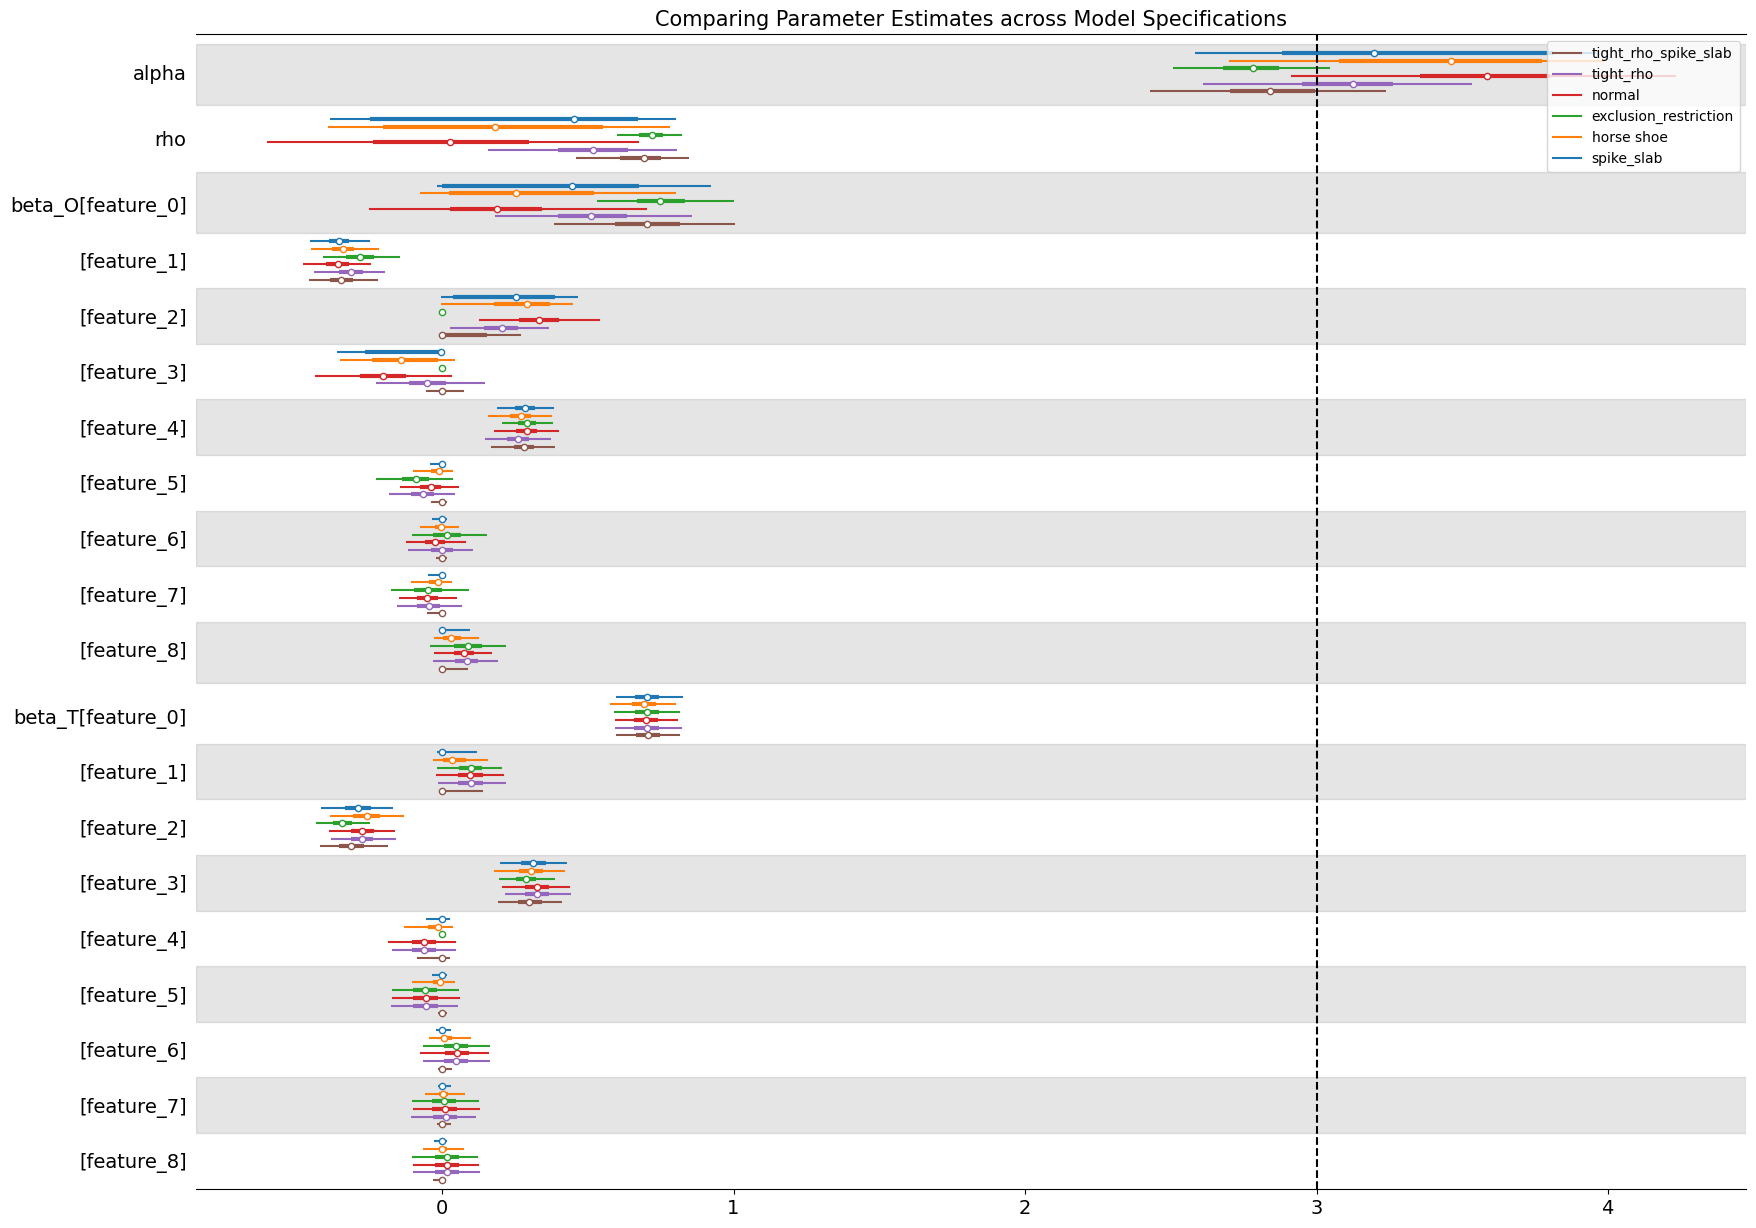

In [11]:
ax = az.plot_forest(
    [
        idata_confounded["spike_and_slab"],
        idata_confounded["horseshoe"],
        idata_confounded["exclusion"],
        idata_confounded["normal"],
        idata_confounded["rho_tight"],
        idata_confounded["rho_tight_spike_slab"],
    ],
    var_names=["alpha", "rho", "beta_O", "beta_T"],
    combined=True,
    model_names=[
        "spike_slab",
        "horse shoe",
        "exclusion_restriction",
        "normal",
        "tight_rho",
        "tight_rho_spike_slab",
    ],
    figsize=(20, 15),
)

ax[0].axvline(3, linestyle="--", color="k")
ax[0].set_title(
    "Comparing Parameter Estimates across Model Specifications", fontsize=15
);

We can see similar patterns in the below pair plots

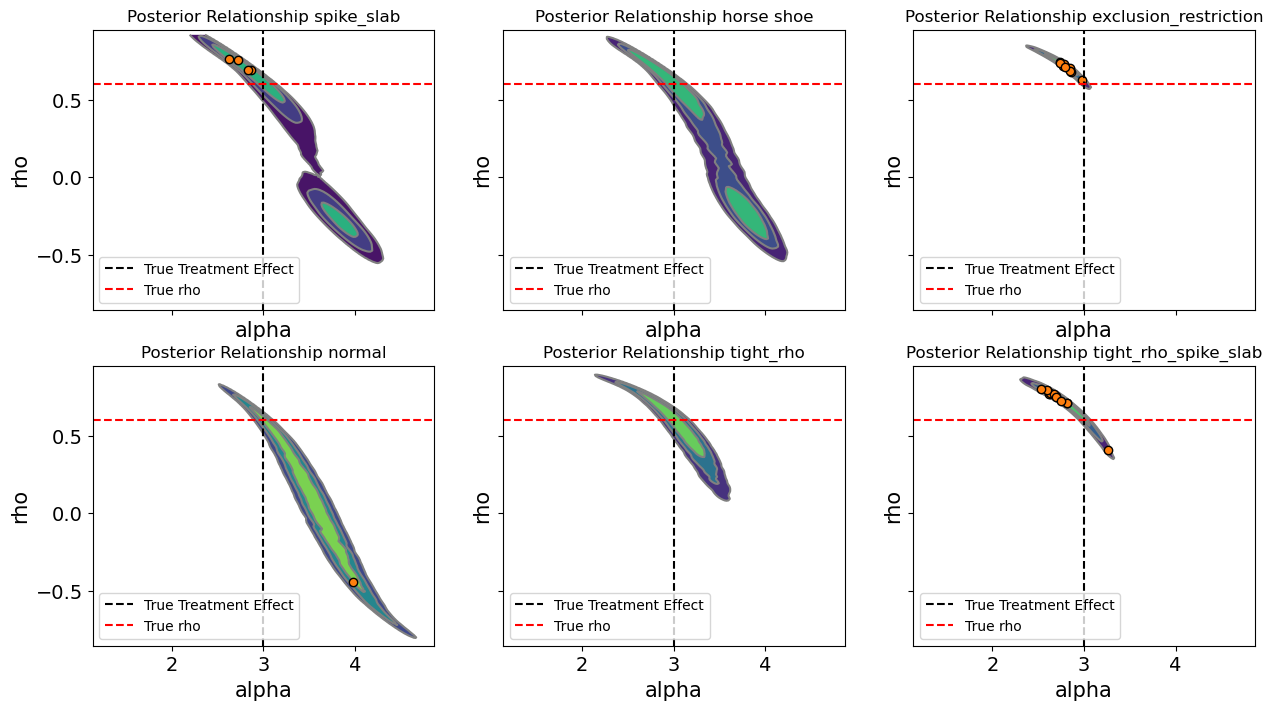

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axs = axs.flatten()
az.plot_pair(
    idata_confounded["spike_and_slab"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[0],
)
az.plot_pair(
    idata_confounded["horseshoe"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[1],
)
az.plot_pair(
    idata_confounded["exclusion"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[2],
)
az.plot_pair(
    idata_confounded["normal"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[3],
)
az.plot_pair(
    idata_confounded["rho_tight"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[4],
)
az.plot_pair(
    idata_confounded["rho_tight_spike_slab"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[5],
)
for ax, m in zip(
    axs,
    [
        "spike_slab",
        "horse shoe",
        "exclusion_restriction",
        "normal",
        "tight_rho",
        "tight_rho_spike_slab",
    ],
):
    ax.axvline(3, linestyle="--", color="k", label="True Treatment Effect")
    ax.axhline(0.6, linestyle="--", color="red", label="True rho")
    ax.set_title(f"Posterior Relationship {m}")
    ax.legend(loc="lower left")

Each panel displays the joint posterior density between these two parameters for a given model specification.

In the baseline normal model, the posteriors of $\alpha$ and $\rho$ exhibit a strong negative association: as the inferred residual correlation decreases, the estimated treatment effect increases. This pattern is characteristic of endogeneity. Part of the treatment’s apparent effect on the outcome is actually explained by unobserved factors that simultaneously drive both. The normal model correctly detects confounding but cannot disentangle its consequences without additional structure, leaving the treatment effect biased.

One other feature evident from the spike and slab and horseshoe models is that the posterior distribution is somewhat bi-modal. The evidence pulls in two ways. There is not sufficient evidence in the data alone for the model to decisively characterise the $\rho$ parameter and this induces a schizphrenic posterior distribution in the $\alpha$ values estimated with these models. 

Introducing tight-$\rho$ priors fundamentally changes this relationship. By constraining the allowable range of to moderate values, we effectively impose an analyst’s belief that the degree of confounding, while nonzero, is not overwhelming. This acts as a form of structural regularization: the posterior of $\alpha$ stabilizes around the true causal effect. In practice, this mirrors what applied analysts often do implicitly. By imposing a weakly informative prior we anchor the model with plausible bounds on endogeneity rather than assuming perfect exogeneity or unbounded correlation. The preference for weakly informative priors here improves the sampling geometry but also clarifies the theoretical position of the analyst. 

In [13]:
df_params = pd.concat(
    {
        "rho_tight": az.summary(
            idata_confounded["rho_tight"], var_names=["alpha", "rho"]
        ),
        "normal": az.summary(idata_confounded["normal"], var_names=["alpha", "rho"]),
        "spike_slab": az.summary(
            idata_confounded["spike_and_slab"], var_names=["alpha", "rho"]
        ),
        "horseshoe": az.summary(
            idata_confounded["horseshoe"], var_names=["alpha", "rho"]
        ),
        "exclusion_restriction": az.summary(
            idata_confounded["exclusion"], var_names=["alpha", "rho"]
        ),
        "tight_rho_spike_slab": az.summary(
            idata_confounded["rho_tight_spike_slab"], var_names=["alpha", "rho"]
        ),
    }
)

df_params

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
rho_tight             alpha  3.088  0.258   2.610    3.532      0.011   
                      rho    0.510  0.174   0.159    0.805      0.006   
normal                alpha  3.578  0.349   2.912    4.233      0.016   
                      rho    0.029  0.358  -0.601    0.675      0.017   
spike_slab            alpha  3.311  0.478   2.584    3.959      0.057   
                      rho    0.247  0.451  -0.383    0.804      0.056   
horseshoe             alpha  3.410  0.405   2.698    3.989      0.021   
                      rho    0.175  0.394  -0.391    0.781      0.020   
exclusion_restriction alpha  2.769  0.147   2.508    3.046      0.004   
                      rho    0.716  0.060   0.600    0.825      0.002   
tight_rho_spike_slab  alpha  2.838  0.220   2.428    3.238      0.008   
                      rho    0.674  0.109   0.461    0.848      0.004   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
rho_tight             alpha    0.011     685.0     697.0   1.00  
                      rho      0.003     688.0     695.0   1.00  
normal                alpha    0.010     459.0     745.0   1.01  
                      rho      0.007     459.0     755.0   1.01  
spike_slab            alpha    0.006      93.0    1076.0   1.03  
                      rho      0.007      94.0    1143.0   1.03  
horseshoe             alpha    0.006     412.0    1357.0   1.00  
                      rho      0.004     413.0    1355.0   1.00  
exclusion_restriction alpha    0.003    1503.0    1807.0   1.00  
                      rho      0.001    1509.0    1871.0   1.00  
tight_rho_spike_slab  alpha    0.005     686.0    1389.0   1.00  
                      rho      0.002     692.0    1233.0   1.00

Across all specifications, the diagnostics tell a consistent story: effective sample sizes are high, `rhat` values hover near 1.00, and divergent transitions are minimal or absent. These are healthy traces, suggesting that the posterior geometries are well-explored and that the models are numerically stable under their respective prior assumptions.

### Causal Identification and Variable Selection

Before continuing to the binary case it's worth diving into the role of priors in these structural causal models. Both spike and slab and horseshoe priors were designed to perform automatic variable selection. The spike-and-slab via a latent mixture of near-zero and freely estimated components, and the horseshoe through continuous shrinkage that allows strong predictors to survive while damping weak or spurious ones. Ultimately these priors determine the multiplicative weights of the $\beta$ coefficients in the model. By placing these variable selection priors on the weights, they are calibrated against the data so as to zero-out those variables that are not required.  

Plotting these posteriors vividly illustrates their behavior more clearly than describing it. 

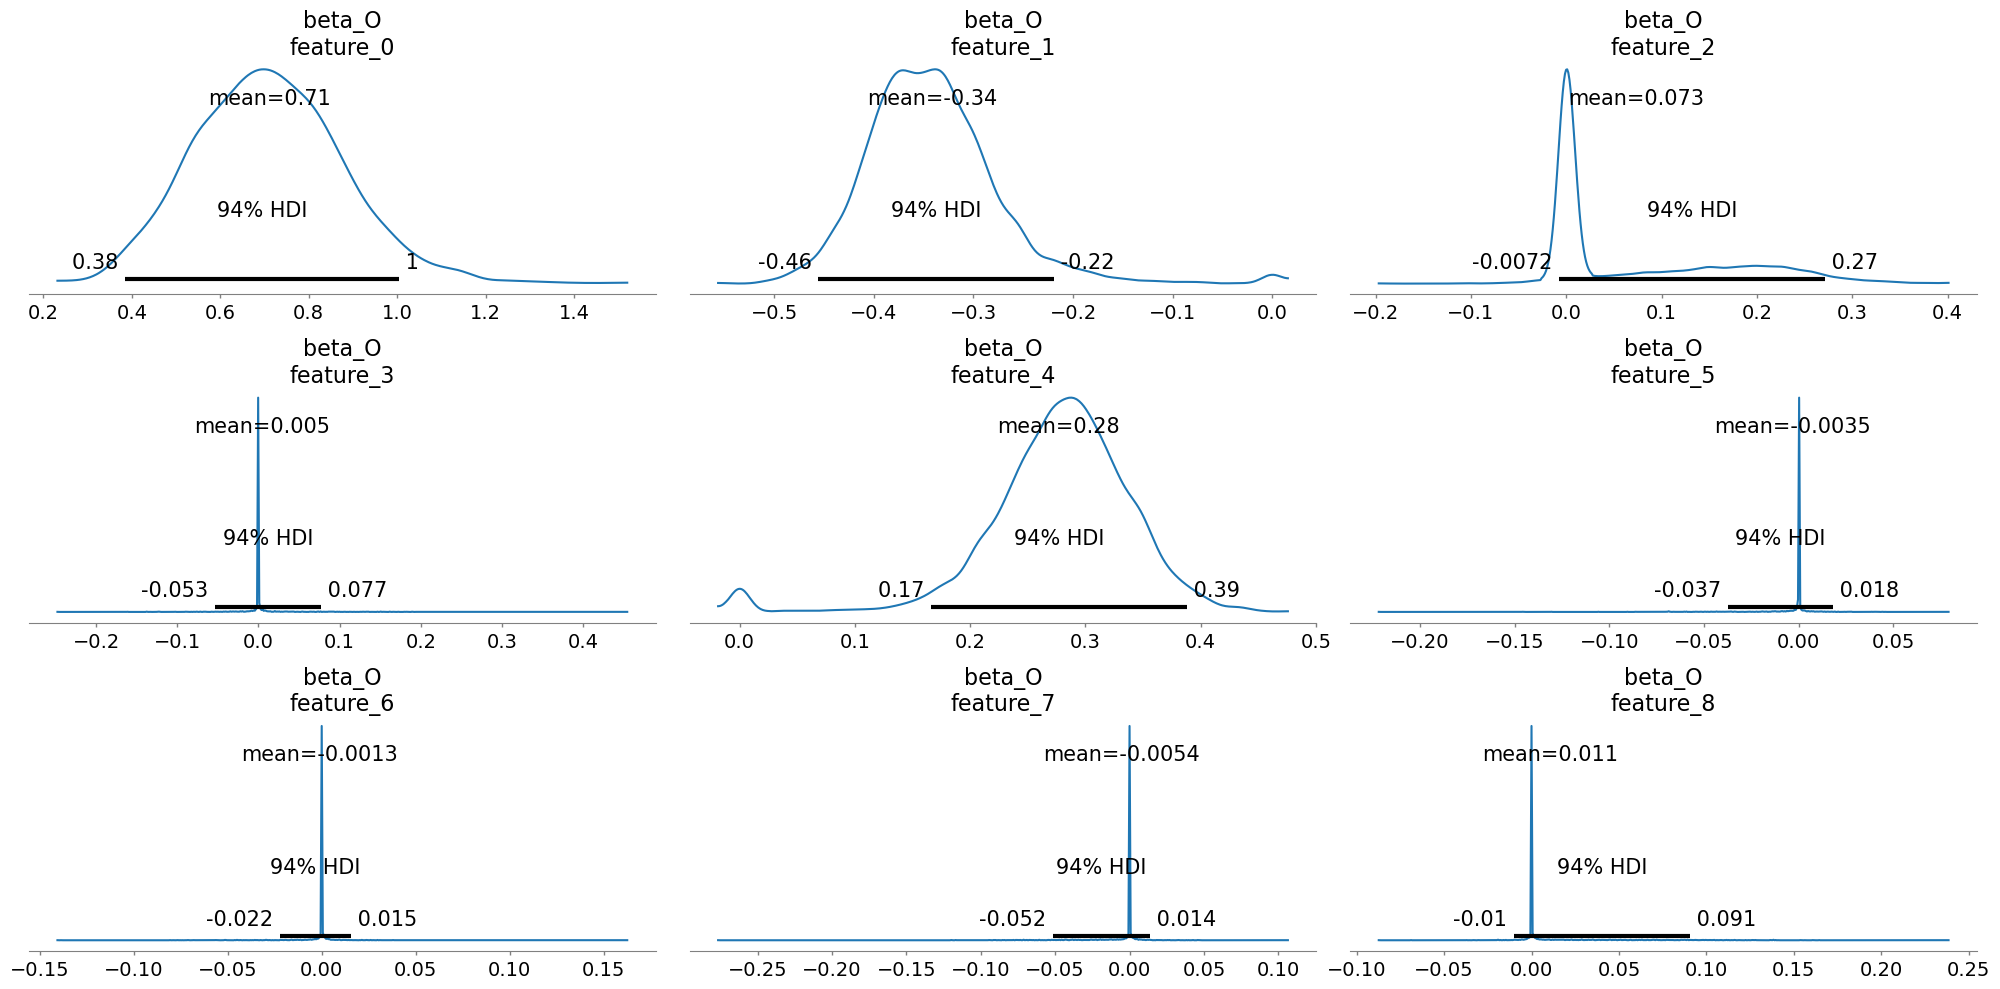

In [14]:
az.plot_posterior(
    idata_confounded["rho_tight_spike_slab"], var_names=["beta_O"], figsize=(20, 10)
)
plt.tight_layout();

This form of Bayesian regularization is crucial when the analyst suspects structural bias i.e. when some covariates may themselves be noise. By letting the model discover and downweight such variables, these priors act as a safeguard against overfitting endogenous structure. Bayesian variable selection is not merely a statistical convenience, but a structural choice about what relationships should be allowed to persist in the causal model. But this behavior should not be mistaken for a _magical salve_ for endogeneity. No prior, however clever, can know which variables are truly exogenous or which exclusion restrictions are defensible. That judgment must come from theory, domain expertise, and a careful causal design. 

Seen this way, these priors are best thought of as complements to theory, not substitutes for it. They are powerful tools for regularization and for exploring the robustness of our inferences, especially in high-dimensional or structurally ambiguous settings. Yet, they should always be deployed with a clear rationale about what the analyst believes to be the relevant sources of variation—and why.

### The Binary Treatment Case

In practice, theory-driven variable selection tends to be more tractable when the treatment is binary. For instance, when a treatment represents a policy adoption, a clinical intervention, or a discrete decision - like entering a program or not. In such settings, the causal question is easier to articulate in design terms: What would have happened if this unit had not received the treatment? Because the intervention is categorical, analysts can often draw on institutional knowledge or policy mechanisms to reason about which variables are genuine confounders, which might serve as instruments, and which can be safely excluded. This clarity of design focus makes the binary treatment context an ideal laboratory for contrasting structural Bayesian modeling with the potential outcomes perspective.

This also allows us to explore how Bayesian joint modeling connects to the potential outcomes framework, where causal effects are conceptualized not just as slopes in a regression, but as differences in counterfactual predictions.To explore this, we adapt our earlier joint modeling setup to the binary treatment context. The model below replaces the continuous treatment equation with a latent variable formulation that links predictors to a Bernoulli decision through a logistic transformation. The latent variables $U$ and $V$ introduce correlated residuals between the outcome and treatment equations, controlled by a correlation parameter $\rho$. This setup captures endogenous selection—the idea that unobserved factors may simultaneously influence both the treatment decision and the outcome.

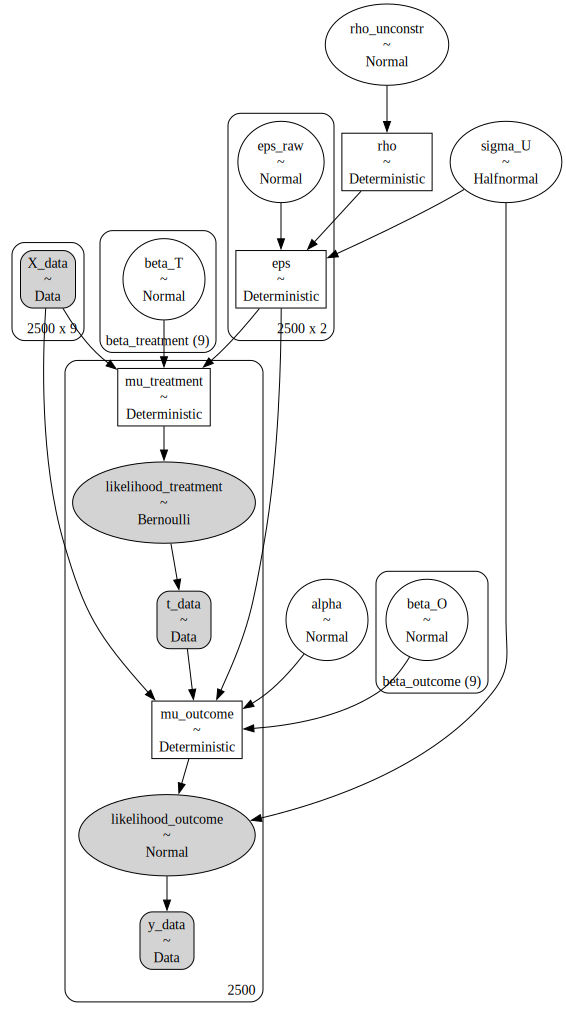

In [35]:
data_confounded = simulate_data(n=2500, alpha_true=3, rho=0.6, cate_estimation=True)


coords = {
    "beta_outcome": [col for col in data_unconfounded.columns if "feature" in col],
    "beta_treatment": [col for col in data_unconfounded.columns if "feature" in col],
    "obs": range(data_unconfounded.shape[0]),
    "latent": ["U", "V"],
    "sigmas_1": ["var_U", "cov_UV"],
    "sigmas_2": ["cov_VU", "var_V"],
}


def make_binary_model(
    data,
    coords,
    bart_treatment=False,
    bart_outcome=False,
    cate_estimation=False,
    X=None,
    Y=None,
    T=None,
    priors=None,
    observed=True,
):
    if X is None:
        X = data[[col for col in data.columns if "feature" in col]]
        Y = data["Y_bin"].values
        T = data["T_bin"].values

    if priors is None:
        priors = {
            "rho": [0, 0.5],
            "alpha": [0, 10],
            "beta_O": [0, 1],
            "eps": [0, 1],
            "sigma_U": [1],
        }

    with pm.Model(coords=coords) as binary_model:
        X_data = pm.Data("X_data", X.values)
        y_data = pm.Data("y_data", Y)
        t_data = pm.Data("t_data", T)

        alpha = pm.Normal("alpha", priors["alpha"][0], priors["alpha"][1])
        sigma_U = pm.HalfNormal("sigma_U", priors["sigma_U"][0])
        # just correlation, not full covariance

        rho_unconstr = pm.Normal("rho_unconstr", priors["rho"][0], priors["rho"][1])
        rho = pm.Deterministic("rho", pm.math.tanh(rho_unconstr))  # keep |rho|<1

        inverse_rho = pm.math.sqrt(pm.math.maximum(1 - rho**2, 1e-12))
        chol = pt.stack([[sigma_U, 0.0], [sigma_U * rho, inverse_rho]])

        # --- Draw latent errors ---
        eps_raw = pm.Normal(
            "eps_raw", priors["eps"][0], priors["eps"][1], shape=(len(data), 2)
        )
        eps = pm.Deterministic("eps", pt.dot(eps_raw, chol.T))

        U = eps[:, 0]
        V = eps[:, 1]

        if bart_treatment:
            mu_treatment = pmb.BART("mu_treatment_bart", X=X_data, Y=t_data) + V
        else:
            beta_treatment = pm.Normal("beta_T", 0, 1, dims="beta_treatment")
            mu_treatment = pm.Deterministic(
                "mu_treatment", (X_data @ beta_treatment) + V
            )
        p_t = pm.math.invlogit(mu_treatment)
        if observed:
            _ = pm.Bernoulli("likelihood_treatment", p_t, observed=t_data)
        else:
            _ = pm.Bernoulli("likelihood_treatment", p_t)

        if cate_estimation:
            pi_O = pm.Beta("pi_O", alpha=2, beta=2)
            alpha_O_raw = pm.Normal("alpha_O_raw", mu=0, sigma=2, dims="beta_outcome")
            gamma_O = relaxed_bernoulli(
                "gamma_O", pi_O, temperature=0.1, dims="beta_outcome"
            )
            alpha_interaction_outcome = pm.Deterministic(
                "alpha_interact", gamma_O * alpha_O_raw, dims="beta_outcome"
            )
            alpha = alpha + pm.math.dot(X_data, alpha_interaction_outcome)

        if bart_outcome:
            mu_outcome = pmb.BART("mu_outcome_bart", X=X_data, Y=y_data) + U
        else:
            beta_outcome = pm.Normal(
                "beta_O", priors["beta_O"][0], priors["beta_O"][1], dims="beta_outcome"
            )
            mu_outcome = pm.Deterministic(
                "mu_outcome", (X_data @ beta_outcome) + alpha * t_data + U
            )

        if observed:
            _ = pm.Normal(
                "likelihood_outcome", mu_outcome, sigma=sigma_U, observed=y_data
            )
        else:
            _ = pm.Normal("likelihood_outcome", mu_outcome, sigma=sigma_U)

    return binary_model


binary_model_bart_treatment = make_binary_model(
    data_confounded, coords, bart_treatment=True
)
binary_model_bart_treatment_cate = make_binary_model(
    data_confounded, coords, bart_treatment=True, cate_estimation=True
)
binary_model = make_binary_model(data_confounded, coords)
binary_model_bart_outcome = make_binary_model(
    data_confounded, coords, bart_outcome=True
)
pm.model_to_graphviz(binary_model)

The nested dependency structure of the model can be seen clearly in the graph above. In the binary setting, the, $\alpha$ parameter captures the average difference in outcomes between treated and untreated units, but as before we are aiming to capture a treatment effect estimate of 3. This model is still bivariate normal in that the latent draws of `eps_raw` are transformed to reflect the correlation encoded in $\rho$. 

$$
\epsilon_{\text{raw}, i} =
\begin{pmatrix} \epsilon_{U,i}^{\text{raw}} \ \epsilon_{V,i}^{\text{raw}} \end{pmatrix}
\sim \mathcal{N}\left(\begin{pmatrix} 0 \ 0 \end{pmatrix}, \mathbf{I}_2\right)
$$

due to the dot product multiplication

$$

\begin{pmatrix} U_i \ V_i \end{pmatrix} = \mathbf{chol} \cdot \epsilon_{\text{raw}, i} \sim \mathcal{N}\left(
\begin{pmatrix} 0 \ 0 \end{pmatrix},
\mathbf{\Sigma} \right)

$$

This is a convenient representation for the bivariate binary case that samples quite efficiently. 

In [16]:
def fit_binary_model(model):
    with model:
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(target_accept=0.95))
    return idata


idata_binary_model_bart_treatment = fit_binary_model(binary_model_bart_treatment)
idata_binary_model = fit_binary_model(binary_model)
idata_binary_bart_outcome = fit_binary_model(binary_model_bart_outcome)
idata_binary_bart_treatment_cate = fit_binary_model(binary_model_bart_treatment_cate)

Sampling: [alpha, beta_O, eps_raw, likelihood_outcome, likelihood_treatment, mu_treatment_bart, rho_unconstr, sigma_U]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, sigma_U, rho_unconstr, eps_raw, beta_O]
>PGBART: [mu_treatment_bart]


Output()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [alpha, beta_O, beta_T, eps_raw, likelihood_outcome, likelihood_treatment, rho_unconstr, sigma_U]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma_U, rho_unconstr, eps_raw, beta_T, beta_O]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [alpha, beta_T, eps_raw, likelihood_outcome, likelihood_treatment, mu_outcome_bart, rho_unconstr, sigma_U]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, sigma_U, rho_unconstr, eps_raw, beta_T]
>PGBART: [mu_outcome_bart]


Output()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [alpha, alpha_O_raw, beta_O, eps_raw, gamma_O_u, likelihood_outcome, likelihood_treatment, mu_treatment_bart, pi_O, rho_unconstr, sigma_U]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, sigma_U, rho_unconstr, eps_raw, pi_O, alpha_O_raw, gamma_O_u, beta_O]
>PGBART: [mu_treatment_bart]


Output()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 232 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Three of our four approaches successfully recover the true causal effect of 3.0, with tight uncertainty bands and accurate confounding estimates. But when BART enters the outcome equation, the results collapse: the treatment effect estimate drops to near-zero. This is not a sampling failure. Diagnostics show healthy chains, good ESS, and converged r-hat values. The model is doing exactly what we asked it to do. The problem is what we asked the model to do!

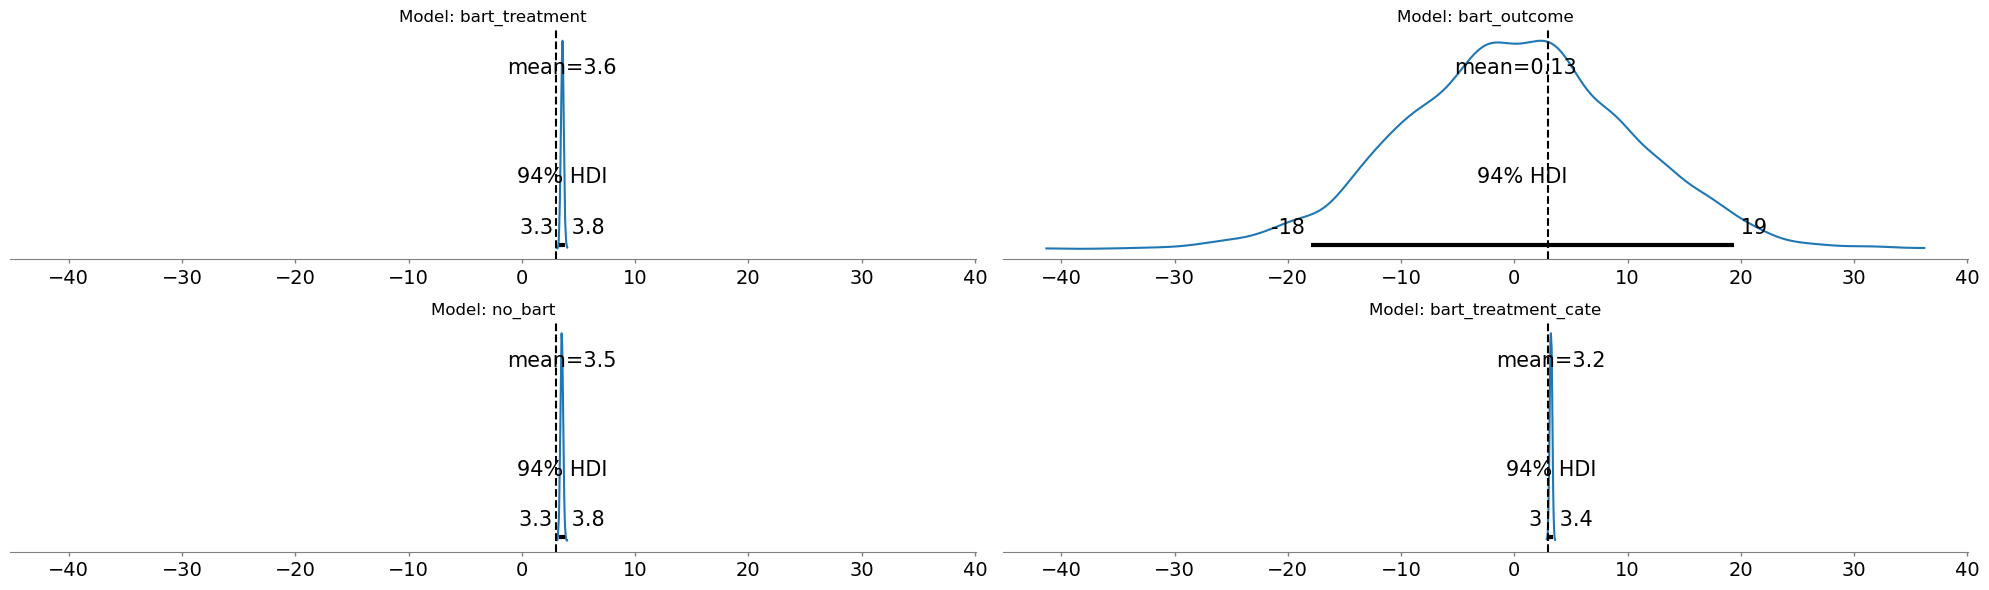

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(20, 6), sharex=True)
axs = axs.flatten()
az.plot_posterior(idata_binary_model_bart_treatment, var_names="alpha", ax=axs[0])
az.plot_posterior(idata_binary_bart_outcome, var_names="alpha", ax=axs[1])
az.plot_posterior(idata_binary_model, var_names="alpha", ax=axs[2])
az.plot_posterior(idata_binary_bart_treatment_cate, var_names="alpha", ax=axs[3])
for ax, title in zip(
    axs, ["bart_treatment", "bart_outcome", "no_bart", "bart_treatment_cate"]
):
    ax.axvline(3, linestyle="--", color="k")
    ax.set_title(f"Model: {title}")

plt.tight_layout()

The failure stems from a fundamental tension between flexibility and causal identification. In our data generating process the treatment is strongly predicted by the covariates. The flexibility of the BART outcome model picks up on this pattern. It learns the total association and does not distinguish causal relationships from association. When we then add a structural parameter α for the treatment effect, we're asking: what is the effect of the treatment _after_ BART has already explained outcome variation using the treatment predictive features. We can see this reflected in the $\rho$ parameter for the BART outcome model. 

In [18]:
pd.concat(
    {
        "linear_no_bart": az.summary(idata_binary_model, var_names=["alpha", "rho"]),
        "bart_treatment": az.summary(
            idata_binary_model_bart_treatment, var_names=["alpha", "rho"]
        ),
        "bart_outcome": az.summary(
            idata_binary_bart_outcome, var_names=["alpha", "rho"]
        ),
        "bart_treatment_cate": az.summary(
            idata_binary_bart_treatment_cate, var_names=["alpha", "rho"]
        ),
    }
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
linear_no_bart      alpha  3.523  0.124   3.297    3.765      0.006    0.003   
                    rho    0.543  0.056   0.433    0.644      0.003    0.001   
bart_treatment      alpha  3.572  0.127   3.320    3.799      0.005    0.003   
                    rho    0.515  0.056   0.402    0.613      0.003    0.001   
bart_outcome        alpha  0.133  9.934 -17.943   19.399      0.132    0.174   
                    rho    0.974  0.011   0.954    0.992      0.000    0.000   
bart_treatment_cate alpha  3.232  0.112   3.017    3.436      0.005    0.002   
                    rho    0.748  0.062   0.631    0.864      0.003    0.001   

                           ess_bulk  ess_tail  r_hat  
linear_no_bart      alpha     506.0     944.0   1.00  
                    rho       424.0     561.0   1.00  
bart_treatment      alpha     543.0    1082.0   1.00  
                    rho       485.0     949.0   1.00  
bart_outcome        alpha    5628.0    2967.0   1.00  
                    rho      2762.0    3148.0   1.00  
bart_treatment_cate alpha     575.0    1197.0   1.01  
                    rho       358.0     668.0   1.02

The `bart_outcome` model places weight on the correlation between treatment and outcome rather than parcel out the share of impact into the treatment and confounding relationship. The causal effect absorbed into the covariate adjustment of the BART component, and we have a fundamental misattribution which makes recovery of structural parameter impossible in this set up. The other two BART model specifications; `bart_treatment` and `bart_treatment_cate` correctly identify the structural parameter because the BART component is used to flexibly model the treatment status. The structural parameter $\alpha$ remains identifiable as the average or baseline effect because we've partialied out the variation in the outcome explicitly. The more traditional `linear_no_bart` model does not have the flexibility to absorb the causal effect into a non-linear component. As such, the structural parameter remains identifiable. This is one of the virtues of "simpler" models. 

### Non-Parametric Causal Inference

We might worry that these parametric approaches to identifying causal effects hide the real lesson. Non-parametric approximation functions can still learn the correct expected value function and we ought to derive causal estimates via the imputation of potential outcomes.

![](../_static/probabilistic_intervention_fix.png)

We should verify that the BART-outcome model's failure isn't merely a problem with how we've extracted the treatment effect parameter $\alpha$. Perhaps the structural parameter collapsed, but the model could still recover causal effects through direct counterfactual imputation. Rather than interpreting a regression coefficient, we directly simulate potential outcomes:

- Fit a model for $E[Y | X, T]$ (however flexible)
- Impute $Y(1)$: Set everyone to treated, predict outcomes
- Impute $Y(0)$: Set everyone to control, predict outcomes
- Compute ATE: Average the difference $Y(1) - Y(0)$

This approach is appealing because it doesn't require interpreting structural parameters. If the model has learned the correct conditional expectation function, counterfactual imputation should recover the true causal effect—even if $\alpha$ itself is uninterpretable. This process of imputation is then repeated across many, many samples to derive the posterior distribution of the treatment effect. 

In [19]:
def impute_potential_outcomes(model, idata, n=2500):
    with model:
        # Posterior predictive under treatment
        pm.set_data({"t_data": np.ones(n, dtype="int")})
        Y1 = pm.sample_posterior_predictive(idata, var_names=["likelihood_outcome"])

        # Posterior predictive under control
        pm.set_data({"t_data": np.zeros(n, dtype="int")})
        Y0 = pm.sample_posterior_predictive(idata, var_names=["likelihood_outcome"])
        ATE = (
            Y1["posterior_predictive"]["likelihood_outcome"]
            - Y0["posterior_predictive"]["likelihood_outcome"]
        ).mean()
        print("Imputed Difference in Potential Outcomes", ATE.item())
    return Y1, Y0, ATE.item()


y1_bart_treatment, y0_bart_treatment, ate_bart_treatment = impute_potential_outcomes(
    binary_model_bart_treatment, idata_binary_model_bart_treatment
)

y1_bart_outcome, y0_bart_outcome, ate_bart_outcome = impute_potential_outcomes(
    binary_model_bart_outcome, idata_binary_bart_outcome
)

y1_no_bart, y0_no_bart, ate_linear = impute_potential_outcomes(
    binary_model, idata_binary_model
)

y1_treatment_cate, y0_treatment_cate, ate_cate = impute_potential_outcomes(
    binary_model_bart_treatment_cate, idata_binary_bart_treatment_cate
)

imputed_effects = pd.DataFrame(
    {
        "model": [
            "bart_treatment",
            "bart_outcome",
            "linear_no_bart",
            "bart_treatment_cate",
        ],
        "ate": [ate_bart_treatment, ate_bart_outcome, ate_linear, ate_cate],
    }
)

Sampling: [likelihood_outcome]


Output()

Sampling: [likelihood_outcome]


Output()

Sampling: [likelihood_outcome]


Output()

Imputed Difference in Potential Outcomes 3.572624967528899


Sampling: [likelihood_outcome]


Output()

Sampling: [likelihood_outcome]


Output()

Imputed Difference in Potential Outcomes -1.65504947266548e-05


Sampling: [likelihood_outcome]


Output()

Sampling: [likelihood_outcome]


Output()

Imputed Difference in Potential Outcomes 3.523751815504299


Sampling: [likelihood_outcome]


Output()

Imputed Difference in Potential Outcomes 3.2318729345313115


In the above code we have applied the following process to impute potential outcomes for each individual under different treatment regimes. 

![](../_static/potential_outcomes.png)

The results are striking in their consistency. For the three successful specifications, both methods of extracting causal effects agree. For the `bart_outcome` specification the Imputation approach to causal inference also fails. This is crucial. The failure is not about how we interrogate the model, but about what the model learned during fitting.

In [20]:
imputed_effects

,model,ate
0,bart_treatment,3.572625
1,bart_outcome,-0.000017
2,linear_no_bart,3.523752
3,bart_treatment_cate,3.231873


In prediction tasks, BART's flexibility is a pure advantage. It finds patterns we didn't know to look for, captures complex interactions automatically, and often achieves superior out-of-sample accuracy. But in causal inference, this same flexibility becomes a liability when it absorbs the variation we're trying to causally attribute. The problem is **structural**: any sufficiently flexible method faces this challenge. Methods that can perfectly adapt their functional form to training data will inadvertently learn causal pathways as associational patterns, unless the structure learning is constrained to partial out the treatment influences. The stronger the relationship between the predictors of the outcome and the treatment, the more we can expect to see this collapse. Flexible outcome modelling may be useful in cases where the relationship between treatment and covariates is truly independent, but it presents a risk where the focus is on recovering treatment effects.

The BART-treatment model demonstrated that flexibility in the treatment equation doesn't harm identification. We can also introduce flexibility in how treatment effects vary with covariates, while preserving the interpretability and identifiability of structural parameters? Our `bart_treatment_cate` model allows this by interacting the treatment parameter with the covariates. This explicitly parameterize effect heterogeneity. Unlike BART in the outcome equation (which failed because it absorbed the entire treatment signal), interaction terms allow treatment effects to vary while retaining a structural interpretation. This allows flexibility while retaining identifiability. 

We can see this flexibility by pulling out the ITE (individual treatment effects) estimates, using the potential outcomes imputations. We can compare the ITEs across the `bart_treatment_cate` and `linear_no_bart` models. 

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_42002/2851777022.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


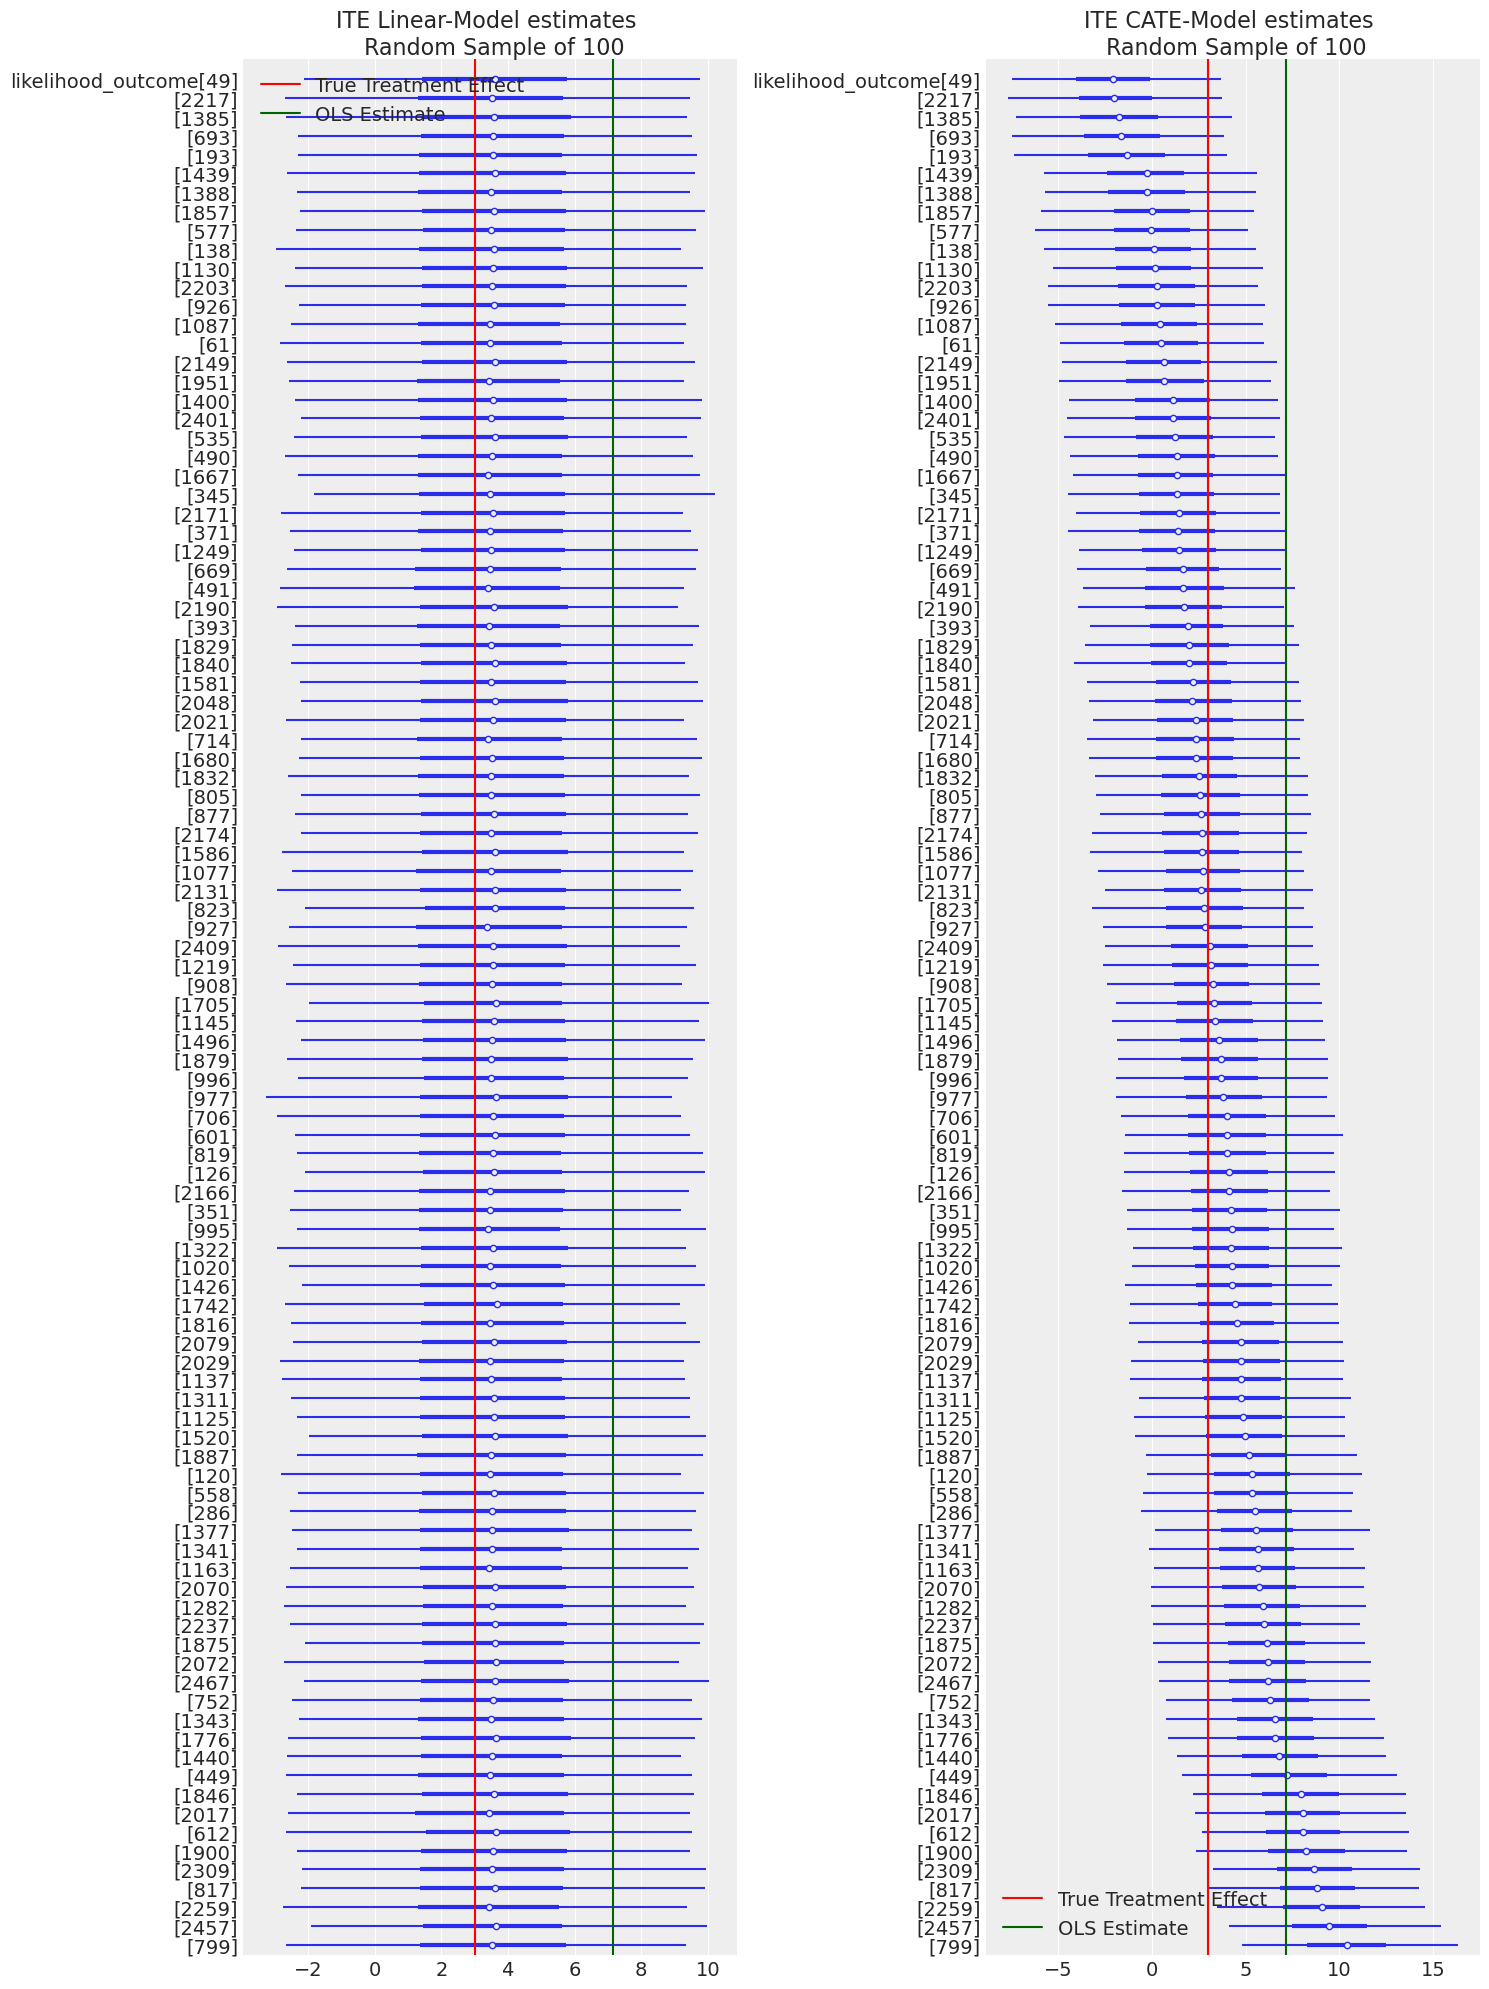

In [37]:
cate = (
    y1_treatment_cate["posterior_predictive"]["likelihood_outcome"]
    - y0_treatment_cate["posterior_predictive"]["likelihood_outcome"]
)


sample_cate = (
    cate.mean(dim=("chain", "draw"))
    .to_dataframe()
    .sample(100)
    .sort_values("likelihood_outcome")
)

cate_linear = (
    y1_no_bart["posterior_predictive"]["likelihood_outcome"]
    - y0_no_bart["posterior_predictive"]["likelihood_outcome"]
)

res = smf.ols(
    "Y_bin ~ T_bin + feature_0 +	feature_1 +	feature_2 +	feature_3 +	feature_4 + feature_5 + feature_6 + feature_7 +feature_8",
    data,
).fit()
ols_est = res.params["T_bin"]

fig, axs = plt.subplots(1, 2, figsize=(15, 20))
axs = axs.flatten()

ax = az.plot_forest(
    cate_linear,
    combined=True,
    figsize=(15, 15),
    coords={"likelihood_outcome_dim_0": sample_cate.index},
    ax=axs[0],
)
axs[0].axvline(3, color="red", label="True Treatment Effect")
axs[0].axvline(ols_est, color="darkgreen", label="OLS Estimate")
axs[0].legend()
axs[0].set_title("ITE Linear-Model estimates \n Random Sample of 100")

ax = az.plot_forest(
    cate,
    combined=True,
    figsize=(15, 10),
    coords={"likelihood_outcome_dim_0": sample_cate.index},
    ax=axs[1],
)
axs[1].axvline(3, color="red", label="True Treatment Effect")
axs[1].axvline(ols_est, color="darkgreen", label="OLS Estimate")
axs[1].set_title("ITE CATE-Model estimates \n Random Sample of 100")
axs[1].legend()
plt.tight_layout();

This comparison shows how the flexibility of treatment effects can be incorporated without losing interpretability. 

### An Empirical Application



We will now explore an example with a real data set from the NHEFS study about the effects of quitting smoking on weight. Ultimately we will compare our estimates of treatment effects to a well specified and sensible regression model. The goal is not to provide the regression estimate as a source of truth, but to show the reasonable diversity of views we can achieve while aiming to estimate causal impact. 

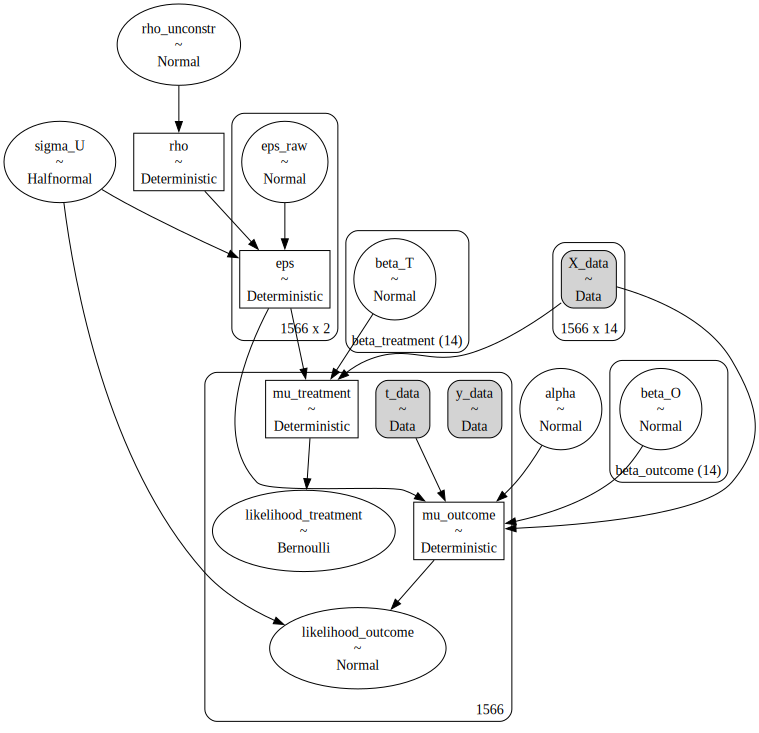

In [39]:
import causalpy as cp

df_nhefs = cp.load_data("nhefs")

features = [
    "age",
    "race",
    "sex",
    "smokeintensity",
    "smokeyrs",
    "wt71",
    "active_1",
    "active_2",
    "education_2",
    "education_3",
    "education_4",
    "education_5",
    "exercise_1",
    "exercise_2",
]
X = df_nhefs[features]
X = (X - X.mean(axis=0)) / X.std(axis=0)
Y = df_nhefs["outcome"].values
T = df_nhefs["trt"].values


coords = {
    "beta_outcome": features,
    "beta_treatment": features,
    "obs": range(df_nhefs.shape[0]),
    "latent": ["U", "V"],
    "sigmas_1": ["var_U", "cov_UV"],
    "sigmas_2": ["cov_VU", "var_V"],
}

priors = {
    "rho": [0.0, 0.5],
    "alpha": [0, 3],
    "beta_O": [0, 3],
    "eps": [0, 1],
    "sigma_U": [0.5],
}

nhefs_binary_model = make_binary_model(
    df_nhefs,
    coords,
    bart_treatment=False,
    cate_estimation=False,
    X=X,
    Y=Y,
    T=T,
    priors=priors,
    observed=False,
)
pm.model_to_graphviz(nhefs_binary_model)

The model is specified without the observed outcomes deliberately. We feed in the predictor $X$ and now we validate how the model specification can recover accurate treatment effects. We forward sample from the system with known parameters. This generates a synthetic observation data that we will feed back into the model, to condition on data known to have been sampled from this model. This makes use of PyMC's do-syntax. We are intervening on the data generating process to set values of the parameters in the system. 

In [23]:
fixed_parameters = {
    "rho": 0.6,
    "alpha": 3,
    "beta_O": [0, 1, 0.4, 0.3, 0.1, 0.8, 0, 0, 0, 0, 0, 0, 3, 0],
    "beta_T": [1, 1.3, 0.5, 0.3, 0.7, 1.6, 0, 0.4, 0, 0, 0, 0, 0, 0],
}
with pm.do(nhefs_binary_model, fixed_parameters) as synthetic_model:
    idata = pm.sample_prior_predictive(
        random_seed=1000
    )  # Sample from prior predictive distribution.
    synthetic_y = idata["prior"]["likelihood_outcome"].sel(draw=0, chain=0)
    synthetic_t = idata["prior"]["likelihood_treatment"].sel(draw=0, chain=0)

Sampling: [eps_raw, likelihood_outcome, likelihood_treatment, rho_unconstr, sigma_U]


We now infer the probable parameters conditioned on the synthetic observed dats. That is, we condition our model on the data generated in our forward pass and attempt the backwards inference. Given the synthetic observations what is the most plausible parameterisation of the world-state that generated the data?

In [24]:
# Infer parameters conditioned on observed data
with pm.observe(
    nhefs_binary_model,
    {"likelihood_outcome": synthetic_y, "likelihood_treatment": synthetic_t},
) as inference_model:
    idata_sim = pm.sample_prior_predictive()
    idata_sim.extend(pm.sample(random_seed=100, chains=4, tune=2000, draws=500))

Sampling: [alpha, beta_O, beta_T, eps_raw, likelihood_outcome, likelihood_treatment, rho_unconstr, sigma_U]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma_U, rho_unconstr, eps_raw, beta_T, beta_O]


Output()

Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The inferential move allows us to accurately recover the focal parameters. 

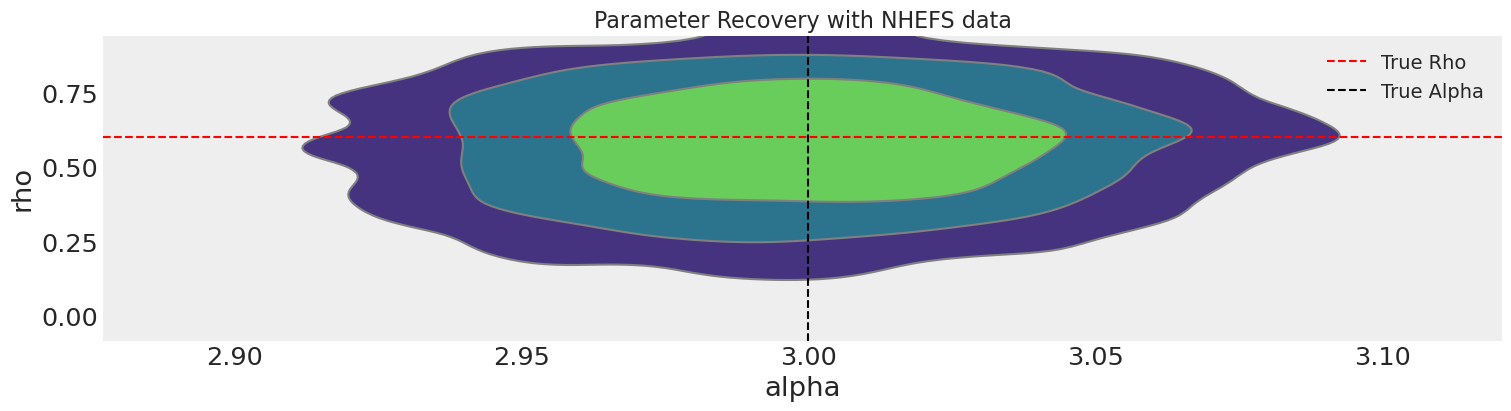

In [25]:
ax = az.plot_pair(idata_sim, var_names=["alpha", "rho"], kind="kde", figsize=(15, 4))
ax.axhline(0.6, linestyle="--", color="red", label="True Rho")
ax.axvline(3, linestyle="--", color="black", label="True Alpha")
ax.set_title("Parameter Recovery with NHEFS data")
ax.legend();

The parameter recovery is also extended to the covariate weights in the system. This is promising. It suggests that our model is able to recover true parameters from the data. 

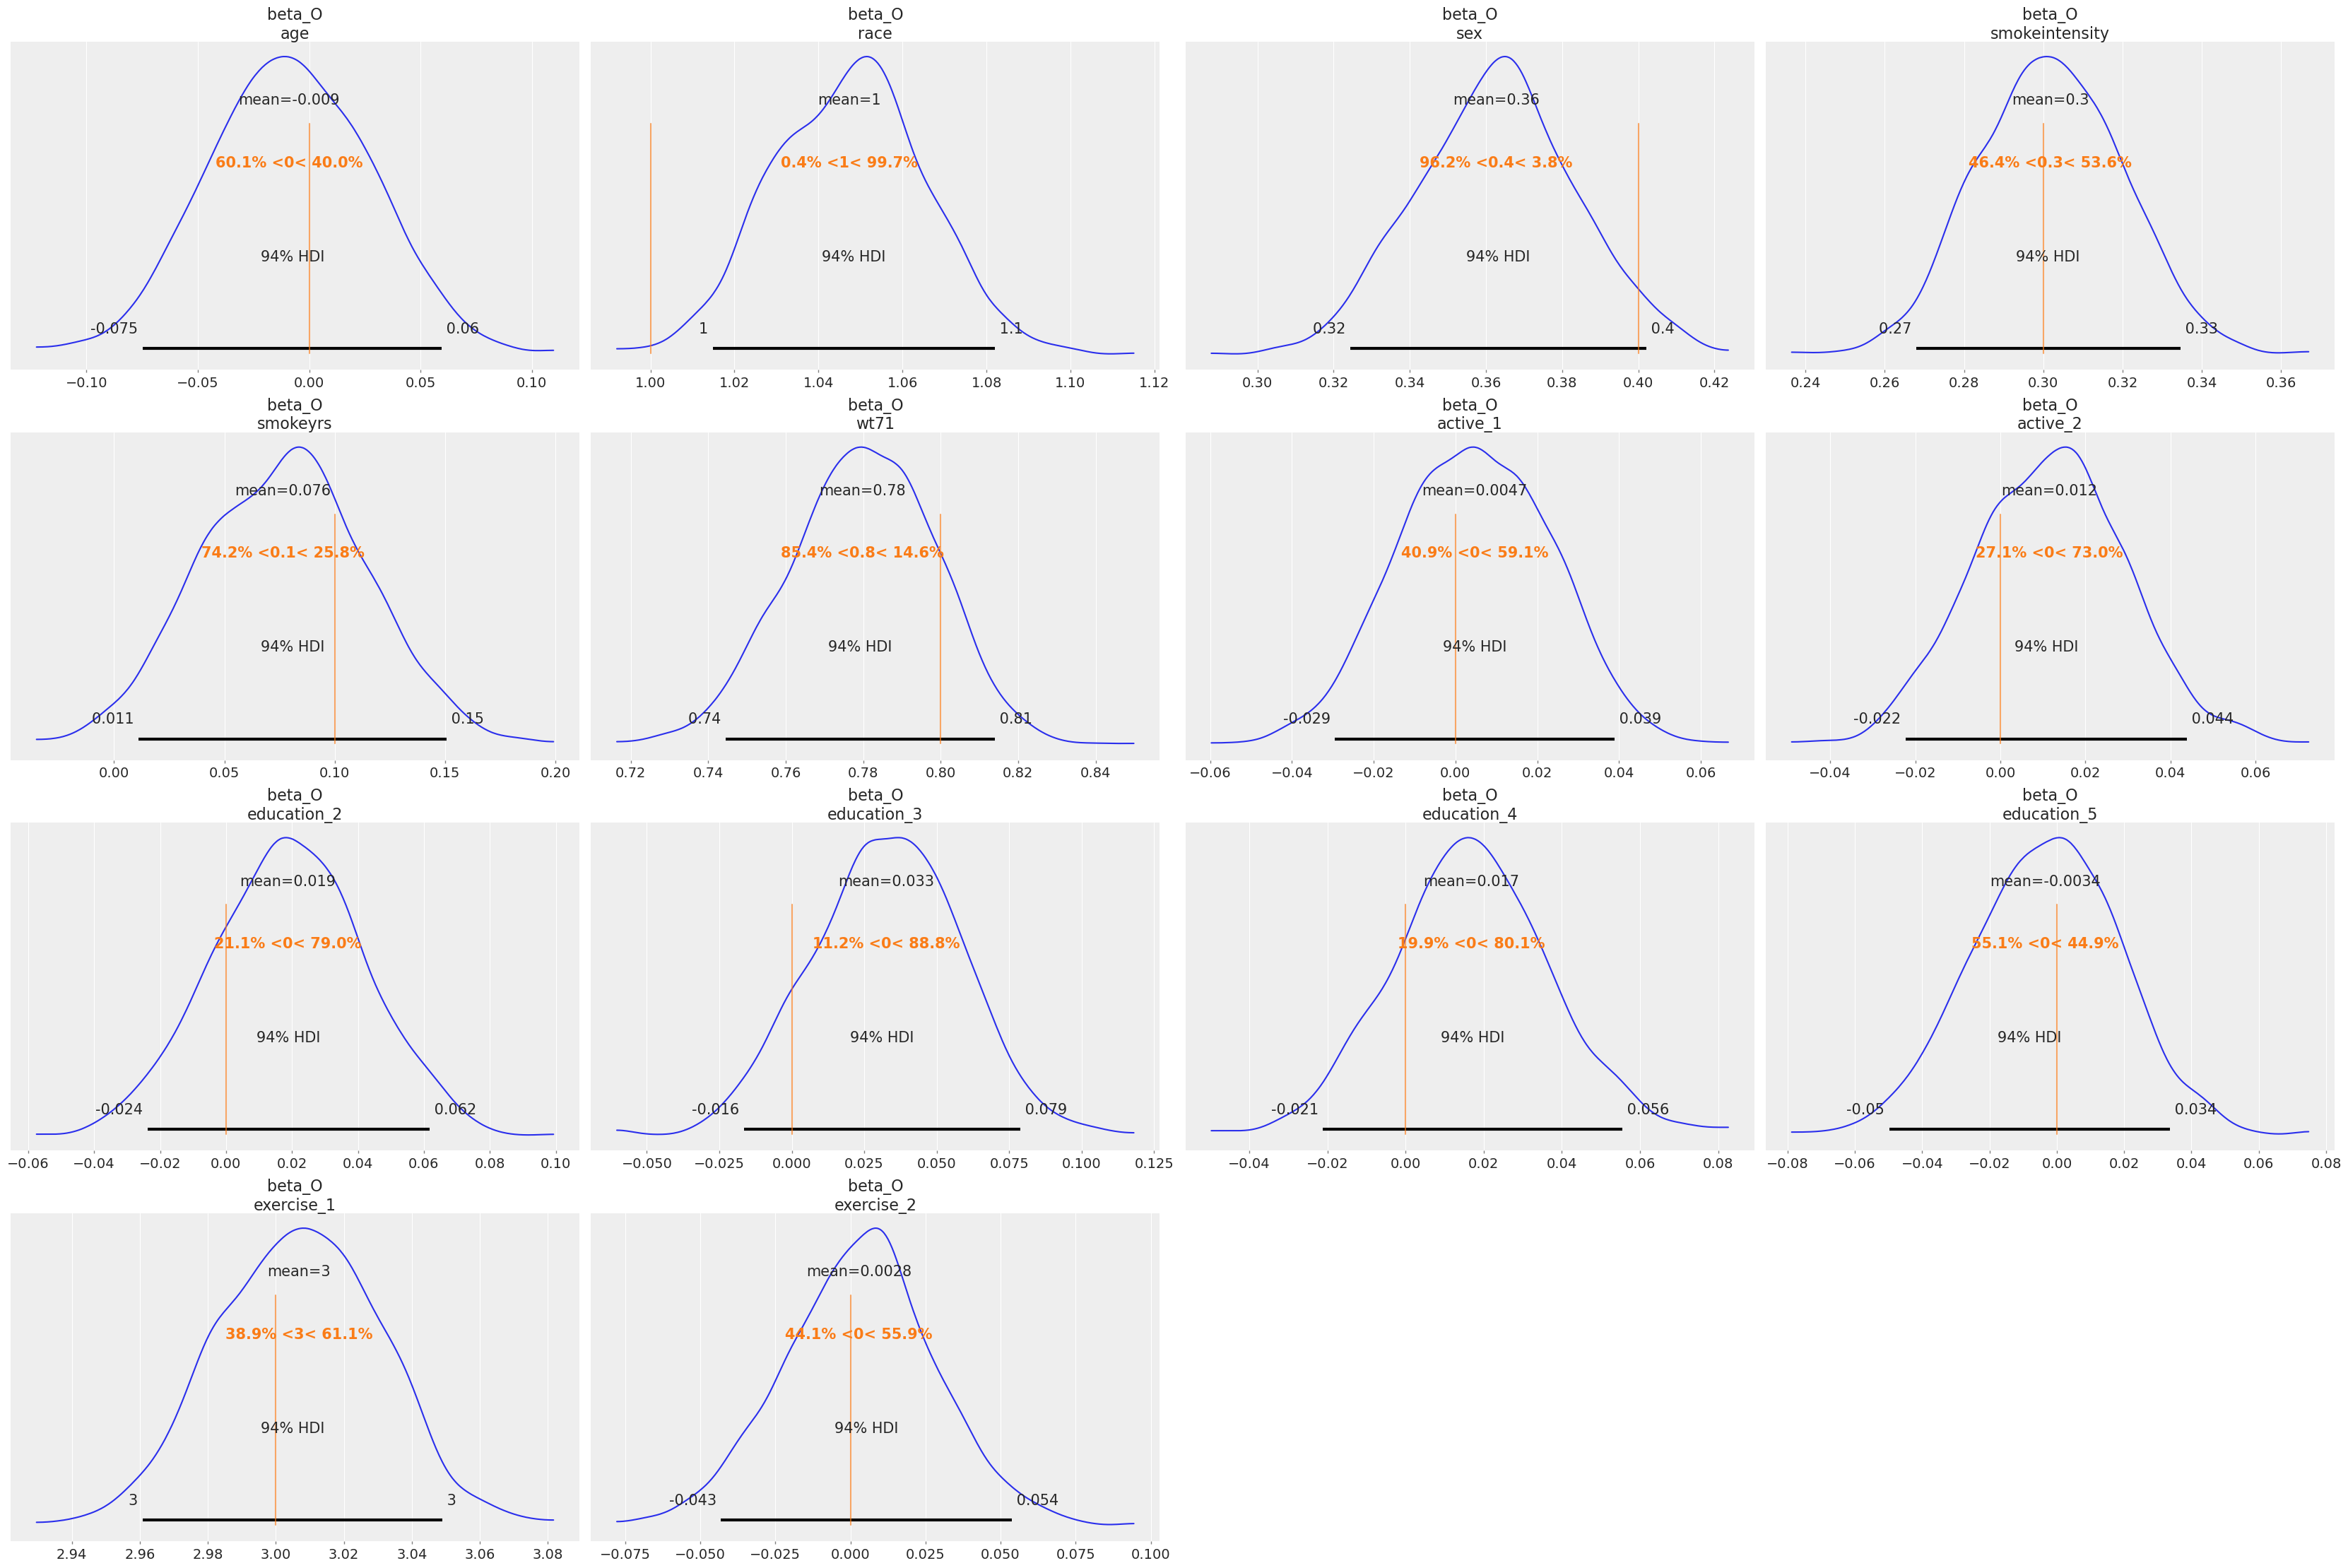

In [26]:
az.plot_posterior(idata_sim, var_names=["beta_O"], ref_val=fixed_parameters["beta_O"]);

Next we will condition on the actual observed data and apply a range of priors to the $\rho$ term to test the sensitivity of our findings to prior weights. 

In [27]:
sampler_kwargs = {
    "tune": 2000,
    "draws": 1000,
    "target_accept": 0.95,
    "mp_ctx": "spawn",
    "random_seed": 1040,
    # "cores": 1
}
priors = {
    "rho": [0.0, 0.5],
    "alpha": [0, 3],
    "beta_O": [0, 3],
    "eps": [0, 1],
    "sigma_U": [0.5],
}
priors_no_confounding = {
    "rho": [0.0, 0.001],
    "alpha": [0, 3],
    "beta_O": [0, 3],
    "eps": [0, 1],
    "sigma_U": [0.5],
}

nhefs_binary_model = make_binary_model(
    df_nhefs,
    coords,
    bart_treatment=False,
    cate_estimation=False,
    X=X,
    Y=Y,
    T=T,
    priors=priors,
    observed=True,
)
nhefs_binary_model_cate = make_binary_model(
    df_nhefs,
    coords,
    bart_treatment=True,
    cate_estimation=True,
    X=X,
    Y=Y,
    T=T,
    priors=priors,
    observed=True,
)
nhefs_binary_model_0_rho = make_binary_model(
    df_nhefs,
    coords,
    bart_treatment=False,
    cate_estimation=False,
    X=X,
    Y=Y,
    T=T,
    priors=priors_no_confounding,
    observed=True,
)

with nhefs_binary_model:
    idata_nhefs = pm.sample_prior_predictive()
    idata_nhefs.extend(pm.sample(**sampler_kwargs))

with nhefs_binary_model_cate:
    idata_nhefs_cate = pm.sample_prior_predictive()
    idata_nhefs_cate.extend(pm.sample(**sampler_kwargs))

with nhefs_binary_model_0_rho:
    idata_nhefs_0_rho = pm.sample_prior_predictive()
    idata_nhefs_0_rho.extend(pm.sample(**sampler_kwargs))

Sampling: [alpha, beta_O, beta_T, eps_raw, likelihood_outcome, likelihood_treatment, rho_unconstr, sigma_U]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma_U, rho_unconstr, eps_raw, beta_T, beta_O]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 37 seconds.
Sampling: [alpha, alpha_O_raw, beta_O, eps_raw, gamma_O_u, likelihood_outcome, likelihood_treatment, mu_treatment_bart, pi_O, rho_unconstr, sigma_U]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, sigma_U, rho_unconstr, eps_raw, pi_O, alpha_O_raw, gamma_O_u, beta_O]
>PGBART: [mu_treatment_bart]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Output()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 177 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [alpha, beta_O, beta_T, eps_raw, likelihood_outcome, likelihood_treatment, rho_unconstr, sigma_U]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma_U, rho_unconstr, eps_raw, beta_T, beta_O]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP:

Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 38 seconds.


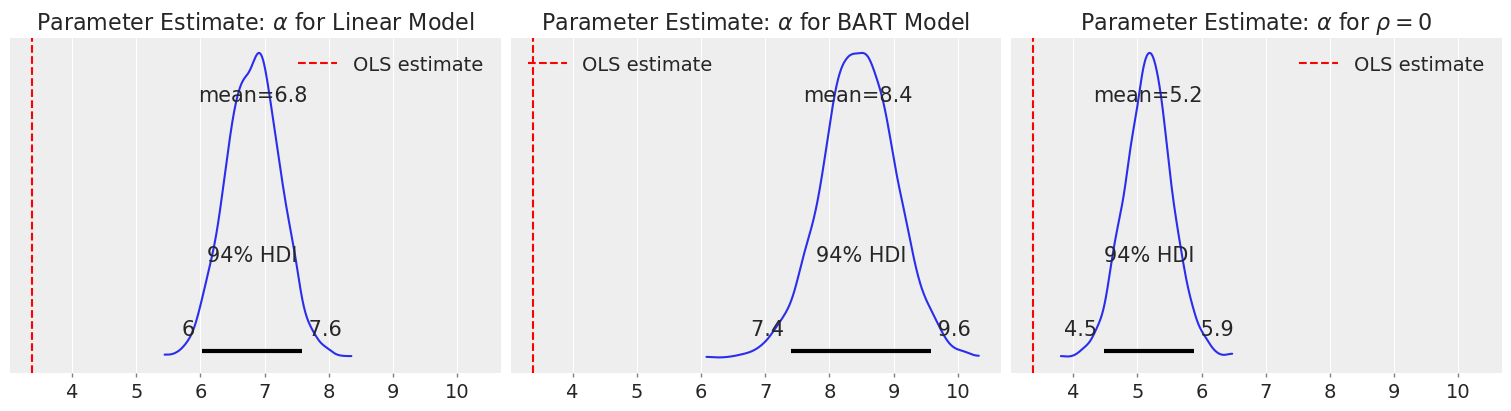

In [40]:
feature_str = " + ".join(features)
formula = "outcome ~ trt +" + feature_str
res = smf.ols(
    formula,
    df_nhefs,
).fit()
ols_est = res.params["trt"]

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
az.plot_posterior(idata_nhefs, var_names="alpha", ax=axs[0])
axs[0].axvline(ols_est, label="OLS estimate", linestyle="--", color="red")
axs[0].set_title(r"Parameter Estimate: $\alpha$ for Linear Model")
az.plot_posterior(idata_nhefs_cate, var_names="alpha", ax=axs[1])
axs[1].set_title(r"Parameter Estimate: $\alpha$ for BART Model")
axs[1].axvline(ols_est, label="OLS estimate", linestyle="--", color="red")
az.plot_posterior(idata_nhefs_0_rho, var_names="alpha", ax=axs[2])
axs[2].set_title(r"Parameter Estimate: $\alpha$ for $\rho = 0$")
axs[2].axvline(ols_est, label="OLS estimate", linestyle="--", color="red")
axs[0].legend()
axs[1].legend()
axs[2].legend();

The results all indicate a positive effect on weight due to the quitting smoking. They vary slightly in the attributed effect but, interestingly even if we try to zero out the correlation between treatment and outcome the model still implies a higher effect than observed in the simpler regression model. 

### Conclusion

When we specify a Bayesian causal model, we write down a probabilistic program that encodes our beliefs about how data are generated. We must consider which variables influence which, how uncertainty enters, and what invariances we are prepared to assume. Once fitted, the model becomes an _executable nomological machine_: we can run it forward under interventions, perturb its assumptions, and observe the probabilistic consequences. This executable character is what distinguishes structural modelling from purely associational approaches. It allows us to simulate alternative worlds and test the coherence of our causal story, rather than merely report coefficients.

The range of model types in `CausalPy` illustrate that there are a range of such programs. Each program is fit to the world in various ways and appropriate for inference contingent on on how well fit each method is to the world. The sensitivity of our findings to perturbations of the program is an important feature of work in causal inference. The virtue of treating causal models as probabilistic programs is therefore twofold. First, it forces us to articulate the structure of our causal beliefs explicitly — the graphical, functional, and stochastic components that make the model run. Second, it offers a disciplined way to explore what follows from those beliefs under uncertainty. In doing so, Bayesian structural causal inference unites an epistemic modesty with the computational rigor of modern probabilistic programming: each model is a local, provisional machine for generating causal understanding, not a final map of the world fit once and forever.

The discovery of these causal programs and quasi-experimental designs is a genuine achievement of _the credibility revolution_, but we can recognize the value of such programmatic abstractions without mistaking their scope for universality. These designs succeed by bracketing complexity rather than modelling it, allowing us to extract causal signals even when the full data-generating process is unknown or only partially knowable. Causal inference succeeds when we know not only how our models work, but also where they stop working. Every causal model, like every fish tank, is a small world whose regularities we can nurture but never universalize. Our task is not to master the ocean, but to build clear tanks and learn when to change the water.